# Data Exploration - Amazon Beauty Products Recommendation System

**Bài toán:** Xây dựng hệ thống gợi ý sản phẩm làm đẹp dựa trên lịch sử đánh giá của người dùng

**Dataset:** Amazon Ratings - Beauty Products

## Mục tiêu:
- Khám phá và hiểu cấu trúc dữ liệu ratings
- Phân tích hành vi người dùng (user behavior)
- Phân tích đặc điểm sản phẩm (product characteristics)
- Phân tích phân phối ratings và patterns
- Đặt câu hỏi và trả lời bằng dữ liệu
- Phát hiện insights cho recommendation system

## 1. Import Libraries

**Yêu cầu:** CHỈ sử dụng NumPy để xử lý dữ liệu, Matplotlib và Seaborn để visualization

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Cấu hình
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.set_printoptions(precision=4, suppress=True)

print(f"NumPy version: {np.__version__}")

NumPy version: 2.0.0


## 2. Load Data using NumPy

Load dữ liệu CSV chỉ bằng NumPy (không dùng Pandas)

In [2]:
# Load CSV data using NumPy
data_path = '../data/raw/ratings_Beauty.csv'

def load_csv_numpy(filepath, delimiter=',', skip_header=True):
    """
    Load CSV file using only NumPy
    Returns: data array, header, user_map, product_map
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # header
    header = lines[0].strip().split(delimiter) if skip_header else None
    
    # data lines
    data_lines = lines[1:] if skip_header else lines
    
    # Preallocate lists for each column
    user_ids = []
    product_ids = []
    ratings = []
    timestamps = []
    
    for line in data_lines:
        parts = line.strip().split(delimiter)
        user_ids.append(parts[0])
        product_ids.append(parts[1])
        ratings.append(float(parts[2]))
        timestamps.append(int(parts[3]) if parts[3].isdigit() else 0)
    
    # convert lists to NumPy arrays
    n_records = len(ratings)
    data = np.zeros((n_records, 4))
    
    # user_ids and product_ids to indices
    unique_users = list(set(user_ids))
    unique_products = list(set(product_ids))
    
    user_id_map = {uid: idx for idx, uid in enumerate(unique_users)}
    product_id_map = {pid: idx for idx, pid in enumerate(unique_products)}
    
    for i in range(n_records):
        data[i, 0] = user_id_map[user_ids[i]]
        data[i, 1] = product_id_map[product_ids[i]]
        data[i, 2] = ratings[i]
        data[i, 3] = timestamps[i]
    
    return data, header, user_id_map, product_id_map


print("Loading data...")
data, header, user_map, product_map = load_csv_numpy(data_path)

print(f"✓ Data loaded successfully!")
print(f"  Shape: {data.shape}")
print(f"  Columns: {header}")
print(f"  Unique users: {len(user_map):,}")
print(f"  Unique products: {len(product_map):,}")

Loading data...
✓ Data loaded successfully!
  Shape: (2023070, 4)
  Columns: ['UserId', 'ProductId', 'Rating', 'Timestamp']
  Unique users: 1,210,271
  Unique products: 249,274


## 3. Basic Data Information

Hiển thị thông tin cơ bản về dataset

In [3]:
# Basic statistics
n_ratings = data.shape[0]
n_users = len(np.unique(data[:, 0]))  # Column 0: UserId
n_products = len(np.unique(data[:, 1]))  # Column 1: ProductId

print(f"Dataset Overview:")
print(f"  Total ratings: {n_ratings:,}")
print(f"  Unique users: {n_users:,}")
print(f"  Unique products: {n_products:,}")

# Sample records
print(f"\nSample Records (first 5):")
print(f"{'UserId':<12} {'ProductId':<12} {'Rating':<10} {'Timestamp'}")
print("-" * 50)
for i in range(min(5, n_ratings)):
    print(f"{data[i, 0]:<12.0f} {data[i, 1]:<12.0f} {data[i, 2]:<10.1f} {data[i, 3]:<12.0f}")

# Sparsity metrics
sparsity = (1 - n_ratings / (n_users * n_products)) * 100
print(f"\nSparsity Metrics:")
print(f"  Potential matrix size: {n_users:,} × {n_products:,}")
print(f"  Sparsity: {sparsity:.4f}%")

Dataset Overview:
  Total ratings: 2,023,070
  Unique users: 1,210,271
  Unique products: 249,274

Sample Records (first 5):
UserId       ProductId    Rating     Timestamp
--------------------------------------------------
713734       215270       5.0        1369699200  
543396       179477       3.0        1355443200  
493602       179477       5.0        1404691200  
924862       119164       4.0        1382572800  
878338       236950       1.0        1274227200  

Sparsity Metrics:
  Potential matrix size: 1,210,271 × 249,274
  Sparsity: 99.9993%


## 4. Descriptive Statistics

Tính toán thống kê mô tả cho ratings sử dụng NumPy

In [81]:
# Extract ratings column
ratings = data[:, 2]

# Central tendency
mean_rating = np.mean(ratings)
median_rating = np.median(ratings)
mode_rating = np.bincount(ratings.astype(int)).argmax()

# Dispersion
std_rating = np.std(ratings)
var_rating = np.var(ratings)
min_rating = np.min(ratings)
max_rating = np.max(ratings)

# Quantiles
q25 = np.percentile(ratings, 25)
q50 = np.percentile(ratings, 50)
q75 = np.percentile(ratings, 75)
iqr = q75 - q25

# Shape metrics (Skewness and Kurtosis)
centered = ratings - mean_rating
skewness = np.mean(centered ** 3) / (std_rating ** 3)
kurtosis = np.mean(centered ** 4) / (std_rating ** 4) - 3

print("Descriptive Statistics for Ratings:")
print(f"\nCentral Tendency:")
print(f"  Mean:   {mean_rating:.4f}")
print(f"  Median: {median_rating:.4f}")
print(f"  Mode:   {mode_rating:.0f}")

print(f"\nDispersion:")
print(f"  Std Dev:  {std_rating:.4f}")
print(f"  Variance: {var_rating:.4f}")
print(f"  Range:    {max_rating - min_rating:.1f} (from {min_rating:.1f} to {max_rating:.1f})")
print(f"  IQR:      {iqr:.4f}")

print(f"\nQuantiles:")
print(f"  Q1 (25%):  {q25:.2f}")
print(f"  Q2 (50%):  {q50:.2f}")
print(f"  Q3 (75%):  {q75:.2f}")

print(f"\nDistribution Shape:")
print(f"  Skewness: {skewness:.4f}", end="")
if skewness < -0.5:
    print(" (left-skewed)")
elif skewness > 0.5:
    print(" (right-skewed)")
else:
    print(" (symmetric)")

print(f"  Kurtosis: {kurtosis:.4f}", end="")
if kurtosis > 0:
    print(" (heavy tails)")
elif kurtosis < 0:
    print(" (light tails)")
else:
    print(" (normal-like)")

Descriptive Statistics for Ratings:

Central Tendency:
  Mean:   4.1490
  Median: 5.0000
  Mode:   5

Dispersion:
  Std Dev:  1.3115
  Variance: 1.7200
  Range:    4.0 (from 1.0 to 5.0)
  IQR:      1.0000

Quantiles:
  Q1 (25%):  4.00
  Q2 (50%):  5.00
  Q3 (75%):  5.00

Distribution Shape:
  Skewness: -1.3914 (left-skewed)
  Kurtosis: 0.5811 (heavy tails)


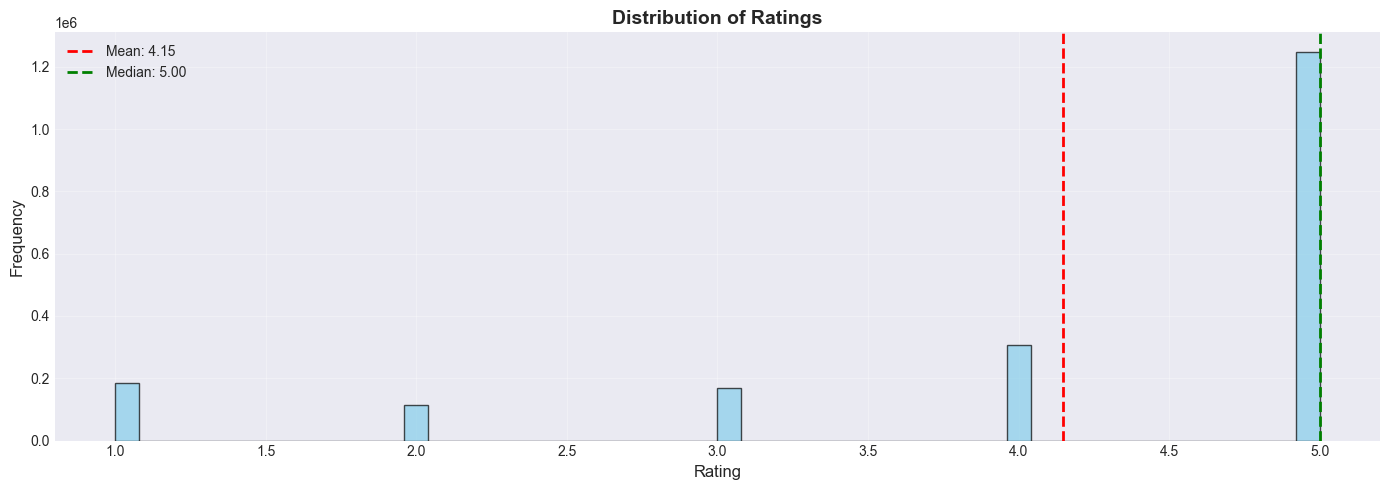

In [112]:
# Visualize rating distribution
fig, ax = plt.subplots(figsize=(14, 5))

# Histogram

ax.hist(ratings, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax.axvline(mean_rating, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rating:.2f}')
ax.axvline(median_rating, color='green', linestyle='--', linewidth=2, label=f'Median: {median_rating:.2f}')
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)



# Add statistics text
stats_text = f"Mean: {mean_rating:.2f}\nMedian: {median_rating:.2f}\nStd: {std_rating:.2f}\nSkew: {skewness:.2f}"

plt.tight_layout()
plt.show()

## 5. Missing Values Analysis

Kiểm tra missing values trong dataset

In [113]:

# NaN values
nan_counts = np.sum(np.isnan(data), axis=0)
total_records = data.shape[0]

column_names = ['UserId', 'ProductId', 'Rating', 'Timestamp']

print(f"\nMissing Values Check:")
print(f"{'Column':<15} {'Missing Count':<15} {'Percentage':<15} {'Status'}")
print("-" * 60)

has_missing = False
for i, col_name in enumerate(column_names):
    missing_count = int(nan_counts[i])
    missing_pct = (missing_count / total_records) * 100
    status = "Clean" if missing_count == 0 else "Has Missing"
    print(f"{col_name:<15} {missing_count:<15,} {missing_pct:<15.2f} {status}")
    if missing_count > 0:
        has_missing = True

if not has_missing:
    print("No missing values detected")
else:
    print("Missing values detected")
# zero values
print(f"\nZero Values Check:")
zero_ratings = np.sum(data[:, 2] == 0)
zero_timestamps = np.sum(data[:, 3] == 0)

print(f" Zero ratings: {zero_ratings:,} ({(zero_ratings/total_records)*100:.2f}%)")
print(f" Zero timestamps: {zero_timestamps:,} ({(zero_timestamps/total_records)*100:.2f}%)")

if zero_ratings > 0:
    print("   Warning: Some ratings are 0 (invalid for 1-5 scale)")

# Visualize missing data
if has_missing or zero_ratings > 0 or zero_timestamps > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    issues = {
        'UserId\nNaN': nan_counts[0],
        'ProductId\nNaN': nan_counts[1],
        'Rating\nNaN': nan_counts[2],
        'Timestamp\nNaN': nan_counts[3],
        'Rating\nZero': zero_ratings,
        'Timestamp\nZero': zero_timestamps
    }
    
    x_pos = np.arange(len(issues))
    counts = list(issues.values())
    colors = ['red' if c > 0 else 'green' for c in counts]
    
    bars = ax.bar(x_pos, counts, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Column / Issue Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Data Quality Issues Overview', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(issues.keys(), rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # add value labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                   f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("\nCompleted")


Missing Values Check:
Column          Missing Count   Percentage      Status
------------------------------------------------------------
UserId          0               0.00            Clean
ProductId       0               0.00            Clean
Rating          0               0.00            Clean
Timestamp       0               0.00            Clean
No missing values detected

Zero Values Check:
 Zero ratings: 0 (0.00%)
 Zero timestamps: 0 (0.00%)

Completed


## 6. Rating Distribution Analysis

### 6.1. Rating Frequency Analysis

In [114]:
# Count frequency of each rating value
rating_values, rating_counts = np.unique(ratings, return_counts=True)
total_ratings = len(ratings)

# Calculate percentages
rating_percentages = (rating_counts / total_ratings) * 100

# Calculate statistics
mean_rating = np.mean(ratings)
median_rating = np.median(ratings)
mode_idx = np.argmax(rating_counts)
mode_rating = rating_values[mode_idx]

print("Rating Frequency Statistics:")
print(f"  Mean Rating: {mean_rating:.4f}")
print(f"  Median Rating: {median_rating:.1f}")
print(f"  Mode Rating: {mode_rating:.0f} (most frequent)")
print(f"  Std Dev: {np.std(ratings):.4f}")

print(f"\nRating Distribution:")
print(f"{'Rating':<10} {'Count':<15} {'Percentage'}")
print("-" * 40)
for val, count, pct in zip(rating_values, rating_counts, rating_percentages):
    print(f"{val:<10.1f} {count:<15,} {pct:.2f}%")

Rating Frequency Statistics:
  Mean Rating: 4.1490
  Median Rating: 5.0
  Mode Rating: 5 (most frequent)
  Std Dev: 1.3115

Rating Distribution:
Rating     Count           Percentage
----------------------------------------
1.0        183,784         9.08%
2.0        113,034         5.59%
3.0        169,791         8.39%
4.0        307,740         15.21%
5.0        1,248,721       61.72%


### 6.2. Rating Sentiment Analysis

In [116]:
# Analyze rating bias
positive_ratings = np.sum(ratings >= 4)  # 4 and 5 stars
negative_ratings = np.sum(ratings <= 2)  # 1 and 2 stars
neutral_ratings = np.sum(ratings == 3)   # 3 stars

positive_pct = (positive_ratings / total_ratings) * 100
negative_pct = (negative_ratings / total_ratings) * 100
neutral_pct = (neutral_ratings / total_ratings) * 100

print("Rating Sentiment Breakdown:")
print(f"  Positive (4-5 stars): {positive_ratings:,} ({positive_pct:.2f}%)")
print(f"  Neutral (3 stars): {neutral_ratings:,} ({neutral_pct:.2f}%)")
print(f"  Negative (1-2 stars): {negative_ratings:,} ({negative_pct:.2f}%)")


Rating Sentiment Breakdown:
  Positive (4-5 stars): 1,556,461 (76.94%)
  Neutral (3 stars): 169,791 (8.39%)
  Negative (1-2 stars): 296,818 (14.67%)


### 6.3. Rating Distribution Visualizations

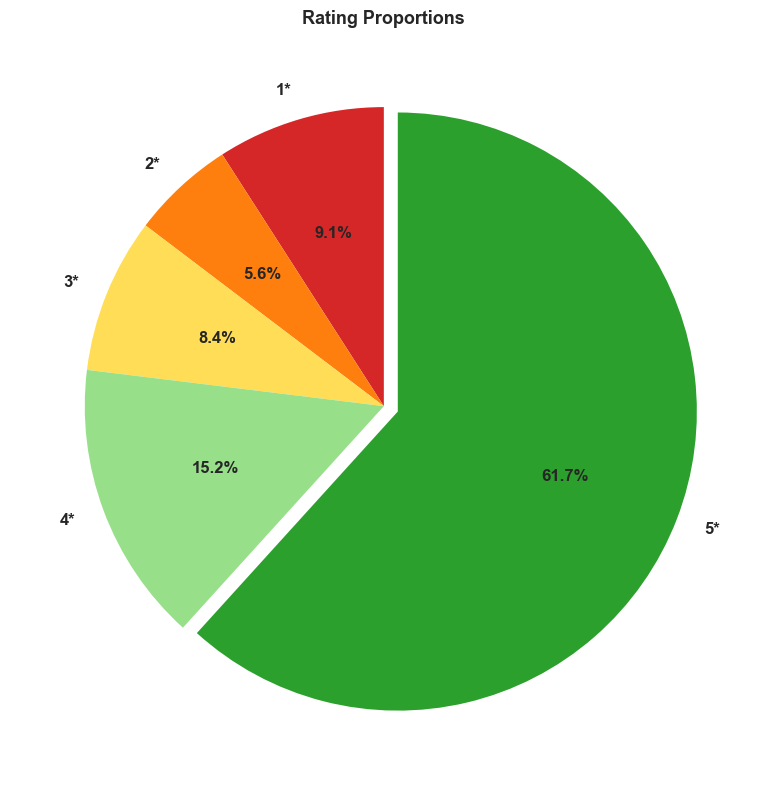

In [122]:
fig, axes = plt.subplots(figsize=(8,8))
colors_bars = ['#d62728', '#ff7f0e', '#ffdd57', '#98df8a', '#2ca02c']


# Pie chart - Rating proportions
explode = [0.05 if pct == max(rating_percentages) else 0 for pct in rating_percentages]
axes.pie(rating_counts, labels=[f'{int(r)}*' for r in rating_values],
        autopct='%1.1f%%', colors=colors_bars, explode=explode,
        startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
axes.set_title('Rating Proportions', fontsize=13, fontweight='bold')



plt.tight_layout()
plt.show()

## 7. User Behavior Analysis

Phân tích hành vi người dùng

### 7.1. User Activity Statistics

In [4]:
# Calculate ratings per user using NumPy
user_ids = data[:, 0]
unique_users, user_rating_counts = np.unique(user_ids, return_counts=True)

n_users = len(unique_users)
total_ratings = len(user_ids)

# Statistics
mean_ratings_per_user = np.mean(user_rating_counts)
median_ratings_per_user = np.median(user_rating_counts)
std_ratings_per_user = np.std(user_rating_counts)
min_ratings_per_user = np.min(user_rating_counts)
max_ratings_per_user = np.max(user_rating_counts)

print("User Activity Statistics:")
print(f"  Total unique users: {n_users:,}")
print(f"  Mean ratings per user: {mean_ratings_per_user:.2f}")
print(f"  Median ratings per user: {median_ratings_per_user:.1f}")
print(f"  Std deviation: {std_ratings_per_user:.2f}")
print(f"  Range: {min_ratings_per_user} to {max_ratings_per_user}")

# Top 10 most active users
top_10_indices = np.argsort(user_rating_counts)[-10:][::-1]
top_10_users = unique_users[top_10_indices]
top_10_counts = user_rating_counts[top_10_indices]

print(f"\nTop 10 Most Active Users:")
print(f"{'Rank':<6} {'User ID':<15} {'# Ratings':<15} {'% of Total'}")
print("-" * 50)
for rank, (user_id, count) in enumerate(zip(top_10_users, top_10_counts), 1):
    pct = (count / total_ratings) * 100
    print(f"{rank:<6} {int(user_id):<15} {count:<15,} {pct:.4f}%")

# Cold start analysis
users_with_le_5_ratings = np.sum(user_rating_counts <= 5)
users_with_le_10_ratings = np.sum(user_rating_counts <= 10)

pct_le_5 = (users_with_le_5_ratings / n_users) * 100
pct_le_10 = (users_with_le_10_ratings / n_users) * 100

print(f"\nCold Start Analysis:")
print(f"  Users with ≤ 5 ratings: {users_with_le_5_ratings:,} ({pct_le_5:.2f}%)")
print(f"  Users with ≤ 10 ratings: {users_with_le_10_ratings:,} ({pct_le_10:.2f}%)")

if pct_le_5 > 50:
    print("  ⚠ High cold start risk - many users have minimal interaction")
else:
    print("  ✓ Moderate cold start problem")

User Activity Statistics:
  Total unique users: 1,210,271
  Mean ratings per user: 1.67
  Median ratings per user: 1.0
  Std deviation: 2.53
  Range: 1 to 389

Top 10 Most Active Users:
Rank   User ID         # Ratings       % of Total
--------------------------------------------------
1      884862          389             0.0192%
2      1133828         336             0.0166%
3      287047          326             0.0161%
4      470150          278             0.0137%
5      601584          276             0.0136%
6      689876          275             0.0136%
7      186790          269             0.0133%
8      254240          259             0.0128%
9      542749          249             0.0123%
10     571605          225             0.0111%

Cold Start Analysis:
  Users with ≤ 5 ratings: 1,174,084 (97.01%)
  Users with ≤ 10 ratings: 1,199,951 (99.15%)
  ⚠ High cold start risk - many users have minimal interaction


In [88]:
# User activity categories
very_active = np.sum(user_rating_counts > 50)
active = np.sum((user_rating_counts > 20) & (user_rating_counts <= 50))
moderate = np.sum((user_rating_counts > 10) & (user_rating_counts <= 20))
occasional = np.sum((user_rating_counts > 5) & (user_rating_counts <= 10))
rare = np.sum((user_rating_counts > 1) & (user_rating_counts <= 5))
one_time = np.sum(user_rating_counts == 1)

print("User Activity Categories:")
print(f"  Very Active (>50): {very_active:,} ({(very_active/n_users)*100:.2f}%)")
print(f"  Active (21-50): {active:,} ({(active/n_users)*100:.2f}%)")
print(f"  Moderate (11-20): {moderate:,} ({(moderate/n_users)*100:.2f}%)")
print(f"  Occasional (6-10): {occasional:,} ({(occasional/n_users)*100:.2f}%)")
print(f"  Rare (2-5): {rare:,} ({(rare/n_users)*100:.2f}%)")
print(f"  One-time (1): {one_time:,} ({(one_time/n_users)*100:.2f}%)")

User Activity Categories:
  Very Active (>50): 344 (0.03%)
  Active (21-50): 2,205 (0.18%)
  Moderate (11-20): 7,771 (0.64%)
  Occasional (6-10): 25,867 (2.14%)
  Rare (2-5): 286,683 (23.69%)
  One-time (1): 887,401 (73.32%)


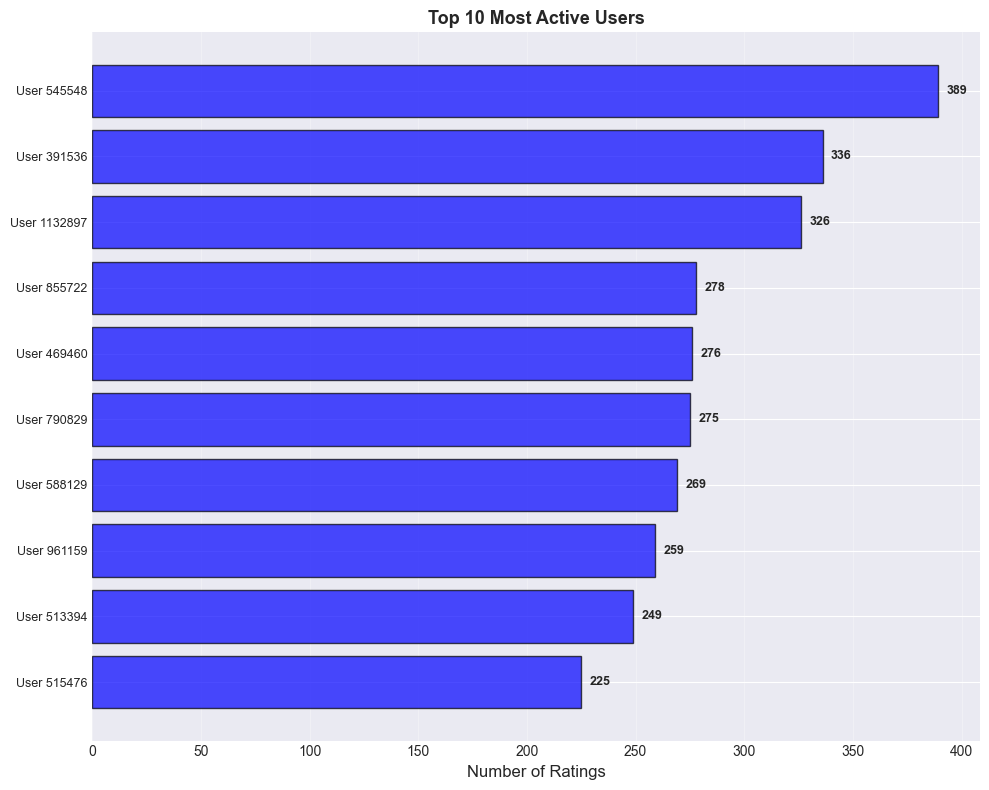

In [126]:
# Visualize user activity
fig, axes = plt.subplots(figsize=(10,8))



# Top 10 most active users
x_pos = np.arange(len(top_10_counts))
bars = axes.barh(x_pos, top_10_counts, color='blue', alpha=0.7, edgecolor='black')
axes.set_yticks(x_pos)
axes.set_yticklabels([f'User {int(uid)}' for uid in top_10_users], fontsize=9)
axes.set_xlabel('Number of Ratings', fontsize=12)
axes.set_title('Top 10 Most Active Users', fontsize=13, fontweight='bold')
axes.invert_yaxis()
axes.grid(True, alpha=0.3, axis='x')

for i, (bar, count) in enumerate(zip(bars, top_10_counts)):
    axes.text(count + max(top_10_counts)*0.01, bar.get_y() + bar.get_height()/2,
            f'{count:,}', va='center', fontsize=9, fontweight='bold')


plt.tight_layout()
plt.show()

### 7.2. User Rating Behavior Analysis

In [90]:
# Calculate user rating statistics (vectorized)
unique_users_arr, inverse_indices = np.unique(user_ids, return_inverse=True)
n_users_total = len(unique_users_arr)

# Count ratings per user
user_n_ratings = np.bincount(inverse_indices)

# Calculate mean ratings per user
rating_sums = np.bincount(inverse_indices, weights=ratings)
user_mean_ratings = rating_sums / user_n_ratings

# Calculate std per user
rating_squared_sums = np.bincount(inverse_indices, weights=ratings**2)
mean_squared = rating_squared_sums / user_n_ratings
user_variance = mean_squared - (user_mean_ratings ** 2)
user_std_ratings = np.sqrt(np.maximum(user_variance, 0))

# Overall statistics
overall_mean = np.mean(user_mean_ratings)
overall_median = np.median(user_mean_ratings)

print("User Rating Behavior Statistics:")
print(f"  Mean of user avg ratings: {overall_mean:.4f}")
print(f"  Median of user avg ratings: {overall_median:.4f}")
print(f"  Min user average: {np.min(user_mean_ratings):.4f}")
print(f"  Max user average: {np.max(user_mean_ratings):.4f}")

# User rating tendencies
harsh_raters = np.sum(user_mean_ratings < 3.0)
generous_raters = np.sum(user_mean_ratings > 4.0)
balanced_raters = np.sum((user_mean_ratings >= 3.0) & (user_mean_ratings <= 4.0))

harsh_pct = (harsh_raters / n_users_total) * 100
generous_pct = (generous_raters / n_users_total) * 100
balanced_pct = (balanced_raters / n_users_total) * 100

print(f"\nUser Rating Tendencies:")
print(f"  Harsh (<3.0): {harsh_raters:,} ({harsh_pct:.2f}%)")
print(f"  Balanced (3.0-4.0): {balanced_raters:,} ({balanced_pct:.2f}%)")
print(f"  Generous (>4.0): {generous_raters:,} ({generous_pct:.2f}%)")

# Rating consistency
users_with_multiple = user_n_ratings > 1
filtered_std = user_std_ratings[users_with_multiple]
n_users_multiple = np.sum(users_with_multiple)

consistent_users = np.sum(filtered_std < 0.5)
moderate_users = np.sum((filtered_std >= 0.5) & (filtered_std < 1.0))
diverse_users = np.sum(filtered_std >= 1.0)

print(f"\nUser Rating Consistency (users with >1 rating):")
print(f"  Consistent (std<0.5): {consistent_users:,} ({(consistent_users/n_users_multiple)*100:.2f}%)")
print(f"  Moderate (0.5-1.0): {moderate_users:,} ({(moderate_users/n_users_multiple)*100:.2f}%)")
print(f"  Diverse (std≥1.0): {diverse_users:,} ({(diverse_users/n_users_multiple)*100:.2f}%)")

User Rating Behavior Statistics:
  Mean of user avg ratings: 4.1158
  Median of user avg ratings: 5.0000
  Min user average: 1.0000
  Max user average: 5.0000

User Rating Tendencies:
  Harsh (<3.0): 178,006 (14.71%)
  Balanced (3.0-4.0): 288,088 (23.80%)
  Generous (>4.0): 744,177 (61.49%)

User Rating Consistency (users with >1 rating):
  Consistent (std<0.5): 161,508 (50.02%)
  Moderate (0.5-1.0): 68,333 (21.16%)
  Diverse (std≥1.0): 93,029 (28.81%)


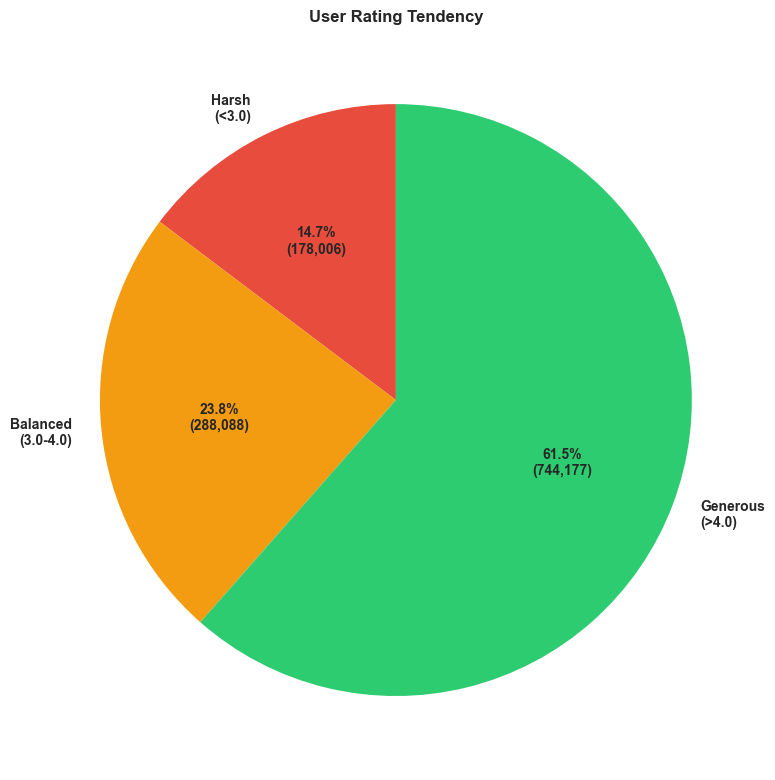

In [129]:
# Visualize user rating behavior
fig, axes = plt.subplots(figsize=(8,8))

# User types pie chart
behavior_names = ['Harsh\n(<3.0)', 'Balanced\n(3.0-4.0)', 'Generous\n(>4.0)']
behavior_counts = np.array([harsh_raters, balanced_raters, generous_raters])
behavior_colors = ['#e74c3c', '#f39c12', '#2ecc71']

axes.pie(behavior_counts, labels=behavior_names,
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*n_users_total):,})',
        colors=behavior_colors, startangle=90,
        textprops={'fontsize': 10, 'weight': 'bold'})
axes.set_title('User Rating Tendency', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Product Analysis

Phân tích đặc điểm sản phẩm

### 8.1. Product Popularity Statistics

In [92]:
# Calculate ratings per product
product_ids = data[:, 1]
unique_products, product_rating_counts = np.unique(product_ids, return_counts=True)

n_products = len(unique_products)
total_ratings = len(product_ids)

# Statistics
mean_ratings_per_product = np.mean(product_rating_counts)
median_ratings_per_product = np.median(product_rating_counts)
std_ratings_per_product = np.std(product_rating_counts)
min_ratings_per_product = np.min(product_rating_counts)
max_ratings_per_product = np.max(product_rating_counts)

print("Product Popularity Statistics:")
print(f"  Total unique products: {n_products:,}")
print(f"  Mean ratings per product: {mean_ratings_per_product:.2f}")
print(f"  Median ratings per product: {median_ratings_per_product:.1f}")
print(f"  Std deviation: {std_ratings_per_product:.2f}")
print(f"  Range: {min_ratings_per_product} to {max_ratings_per_product}")

# Top 20 most reviewed products
top_20_indices = np.argsort(product_rating_counts)[-20:][::-1]
top_20_products = unique_products[top_20_indices]
top_20_counts = product_rating_counts[top_20_indices]

print(f"\nTop 20 Most Reviewed Products:")
print(f"{'Rank':<6} {'Product ID':<15} {'# Ratings':<15} {'% of Total'}")
print("-" * 50)
for rank, (product_id, count) in enumerate(zip(top_20_products, top_20_counts), 1):
    pct = (count / total_ratings) * 100
    print(f"{rank:<6} {int(product_id):<15} {count:<15,} {pct:.4f}%")

# Cold start problem
products_with_lt_5_ratings = np.sum(product_rating_counts < 5)
products_with_lt_10_ratings = np.sum(product_rating_counts < 10)

pct_lt_5 = (products_with_lt_5_ratings / n_products) * 100
pct_lt_10 = (products_with_lt_10_ratings / n_products) * 100

print(f"\nProduct Cold Start Analysis:")
print(f"  Products with < 5 ratings: {products_with_lt_5_ratings:,} ({pct_lt_5:.2f}%)")
print(f"  Products with < 10 ratings: {products_with_lt_10_ratings:,} ({pct_lt_10:.2f}%)")

if pct_lt_5 > 50:
    print("  ⚠ High cold start risk for products")
elif pct_lt_5 > 30:
    print("  ⚠ Moderate cold start problem")
else:
    print("  ✓ Low cold start problem")

Product Popularity Statistics:
  Total unique products: 249,274
  Mean ratings per product: 8.12
  Median ratings per product: 2.0
  Std deviation: 36.06
  Range: 1 to 7533

Top 20 Most Reviewed Products:
Rank   Product ID      # Ratings       % of Total
--------------------------------------------------
1      37489           7,533           0.3724%
2      86036           2,869           0.1418%
3      4879            2,477           0.1224%
4      65026           2,143           0.1059%
5      123424          2,088           0.1032%
6      5647            2,041           0.1009%
7      75219           1,918           0.0948%
8      2012            1,885           0.0932%
9      202159          1,838           0.0909%
10     236486          1,589           0.0785%
11     62220           1,558           0.0770%
12     177238          1,475           0.0729%
13     185205          1,468           0.0726%
14     49908           1,430           0.0707%
15     17815           1,379        

In [93]:
# Product popularity categories
blockbuster = np.sum(product_rating_counts > 100)
popular = np.sum((product_rating_counts > 50) & (product_rating_counts <= 100))
moderate = np.sum((product_rating_counts >= 20) & (product_rating_counts <= 50))
niche = np.sum((product_rating_counts >= 10) & (product_rating_counts < 20))
unpopular = np.sum((product_rating_counts >= 5) & (product_rating_counts < 10))
rare = np.sum(product_rating_counts < 5)

print("Product Popularity Categories:")
print(f"  Blockbuster (>100): {blockbuster:,} ({(blockbuster/n_products)*100:.2f}%)")
print(f"  Popular (51-100): {popular:,} ({(popular/n_products)*100:.2f}%)")
print(f"  Moderate (20-50): {moderate:,} ({(moderate/n_products)*100:.2f}%)")
print(f"  Niche (10-19): {niche:,} ({(niche/n_products)*100:.2f}%)")
print(f"  Unpopular (5-9): {unpopular:,} ({(unpopular/n_products)*100:.2f}%)")
print(f"  Rare (<5): {rare:,} ({(rare/n_products)*100:.2f}%)")

Product Popularity Categories:
  Blockbuster (>100): 2,687 (1.08%)
  Popular (51-100): 4,110 (1.65%)
  Moderate (20-50): 12,298 (4.93%)
  Niche (10-19): 17,843 (7.16%)
  Unpopular (5-9): 30,407 (12.20%)
  Rare (<5): 181,929 (72.98%)


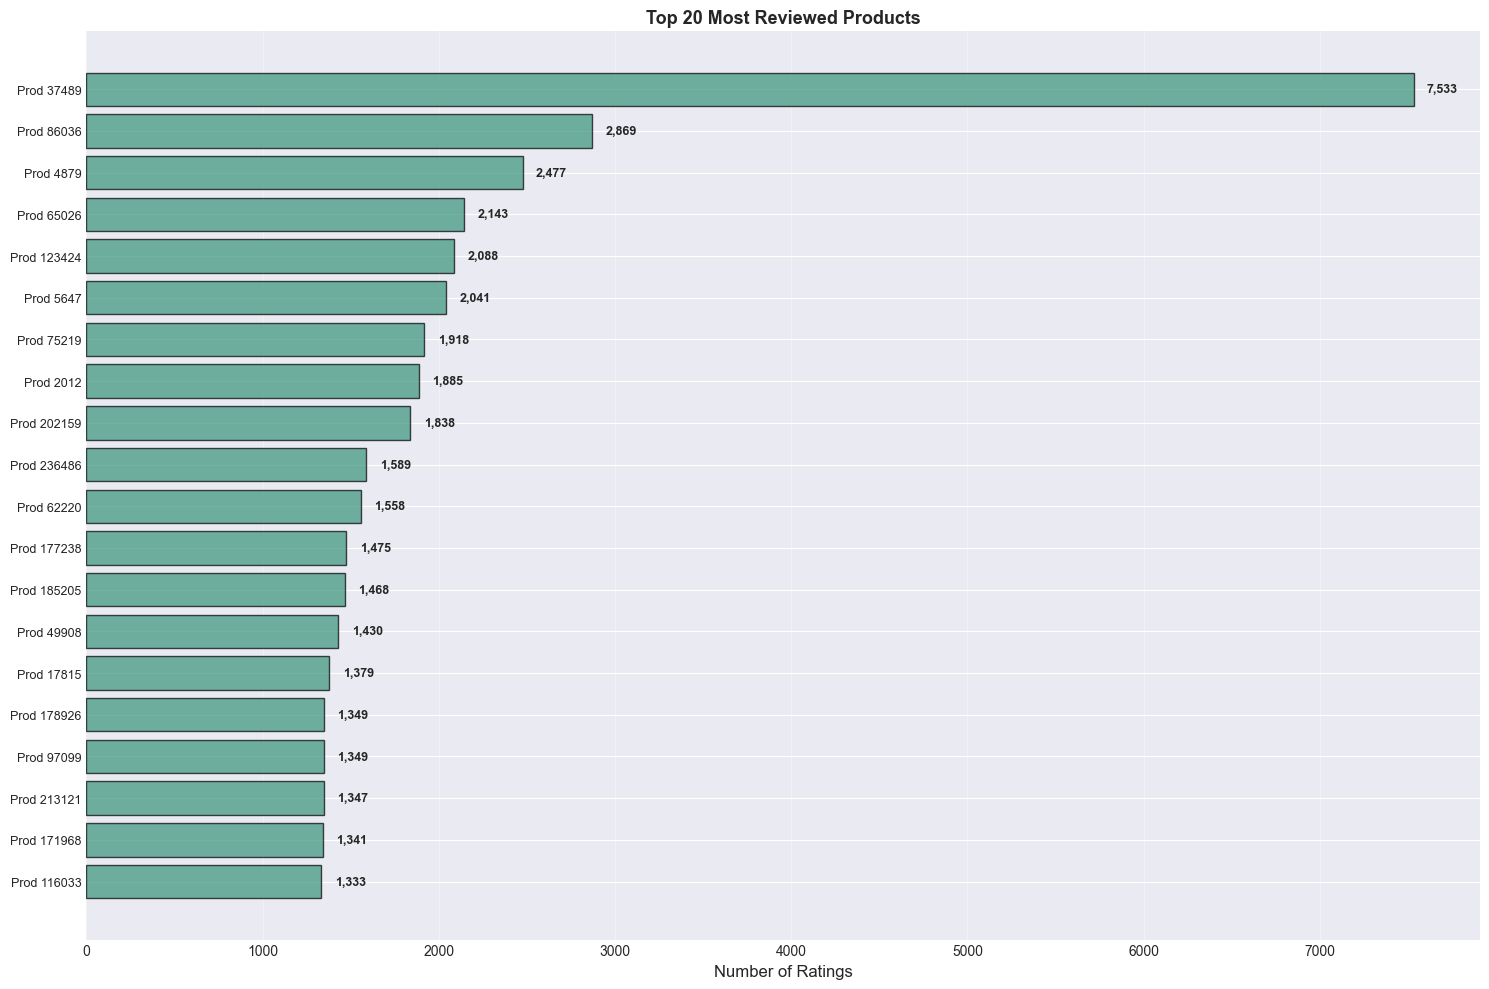

In [94]:
# Visualize product popularity
fig, axes = plt.subplots(figsize=(15, 10))

# Top 20 bar chart

x_pos = np.arange(len(top_20_counts))
bars = axes.barh(x_pos, top_20_counts, color="#389379", alpha=0.7, edgecolor='black')
axes.set_yticks(x_pos)
axes.set_yticklabels([f'Prod {int(pid)}' for pid in top_20_products], fontsize=9)
axes.set_xlabel('Number of Ratings', fontsize=12)
axes.set_title('Top 20 Most Reviewed Products', fontsize=13, fontweight='bold')
axes.invert_yaxis()
axes.grid(True, alpha=0.3, axis='x')

for i, (bar, count) in enumerate(zip(bars, top_20_counts)):
    axes.text(count + max(top_20_counts)*0.01, bar.get_y() + bar.get_height()/2,
            f'{count:,}', va='center', fontsize=9, fontweight='bold')


plt.tight_layout()
plt.show()

### 8.2. Product Quality Analysis

In [95]:
# Calculate product rating statistics (vectorized)
unique_products_sorted, inverse_indices_products = np.unique(product_ids, return_inverse=True)
n_products_total = len(unique_products_sorted)

# Number of ratings per product
product_n_ratings = np.bincount(inverse_indices_products)

# Mean ratings per product
rating_sums_products = np.bincount(inverse_indices_products, weights=ratings)
product_mean_ratings = rating_sums_products / product_n_ratings

# Std ratings per product
rating_squared_sums_products = np.bincount(inverse_indices_products, weights=ratings**2)
mean_squared_products = rating_squared_sums_products / product_n_ratings
product_variance = mean_squared_products - (product_mean_ratings ** 2)
product_std_ratings = np.sqrt(np.maximum(product_variance, 0))

# Overall statistics
overall_mean_quality = np.mean(product_mean_ratings)
overall_median_quality = np.median(product_mean_ratings)

print("Product Quality Statistics:")
print(f"  Mean of product avg ratings: {overall_mean_quality:.4f}")
print(f"  Median of product avg ratings: {overall_median_quality:.4f}")
print(f"  Min product average: {np.min(product_mean_ratings):.4f}")
print(f"  Max product average: {np.max(product_mean_ratings):.4f}")

# Quality categories
excellent = np.sum(product_mean_ratings >= 4.5)
good = np.sum((product_mean_ratings >= 4.0) & (product_mean_ratings < 4.5))
average = np.sum((product_mean_ratings >= 3.0) & (product_mean_ratings < 4.0))
poor = np.sum((product_mean_ratings >= 2.0) & (product_mean_ratings < 3.0))
very_poor = np.sum(product_mean_ratings < 2.0)

print(f"\nProduct Quality Categories:")
print(f"  Excellent (≥4.5): {excellent:,} ({(excellent/n_products_total)*100:.2f}%)")
print(f"  Good (4.0-4.5): {good:,} ({(good/n_products_total)*100:.2f}%)")
print(f"  Average (3.0-4.0): {average:,} ({(average/n_products_total)*100:.2f}%)")
print(f"  Poor (2.0-3.0): {poor:,} ({(poor/n_products_total)*100:.2f}%)")
print(f"  Very Poor (<2.0): {very_poor:,} ({(very_poor/n_products_total)*100:.2f}%)")

# Controversy analysis
products_with_multiple = product_n_ratings > 1
filtered_product_std = product_std_ratings[products_with_multiple]
n_products_multiple = np.sum(products_with_multiple)

controversial = np.sum(filtered_product_std >= 1.5)
mixed = np.sum((filtered_product_std >= 1.0) & (filtered_product_std < 1.5))
consistent = np.sum(filtered_product_std < 1.0)

print(f"\nProduct Rating Controversy (products with >1 rating):")
print(f"  Consistent (std<1.0): {consistent:,} ({(consistent/n_products_multiple)*100:.2f}%)")
print(f"  Mixed (1.0-1.5): {mixed:,} ({(mixed/n_products_multiple)*100:.2f}%)")
print(f"  Controversial (std≥1.5): {controversial:,} ({(controversial/n_products_multiple)*100:.2f}%)")

Product Quality Statistics:
  Mean of product avg ratings: 4.1493
  Median of product avg ratings: 4.5000
  Min product average: 1.0000
  Max product average: 5.0000

Product Quality Categories:
  Excellent (≥4.5): 128,178 (51.42%)
  Good (4.0-4.5): 52,052 (20.88%)
  Average (3.0-4.0): 43,681 (17.52%)
  Poor (2.0-3.0): 13,617 (5.46%)
  Very Poor (<2.0): 11,746 (4.71%)

Product Rating Controversy (products with >1 rating):
  Consistent (std<1.0): 77,366 (53.07%)
  Mixed (1.0-1.5): 40,227 (27.59%)
  Controversial (std≥1.5): 28,197 (19.34%)


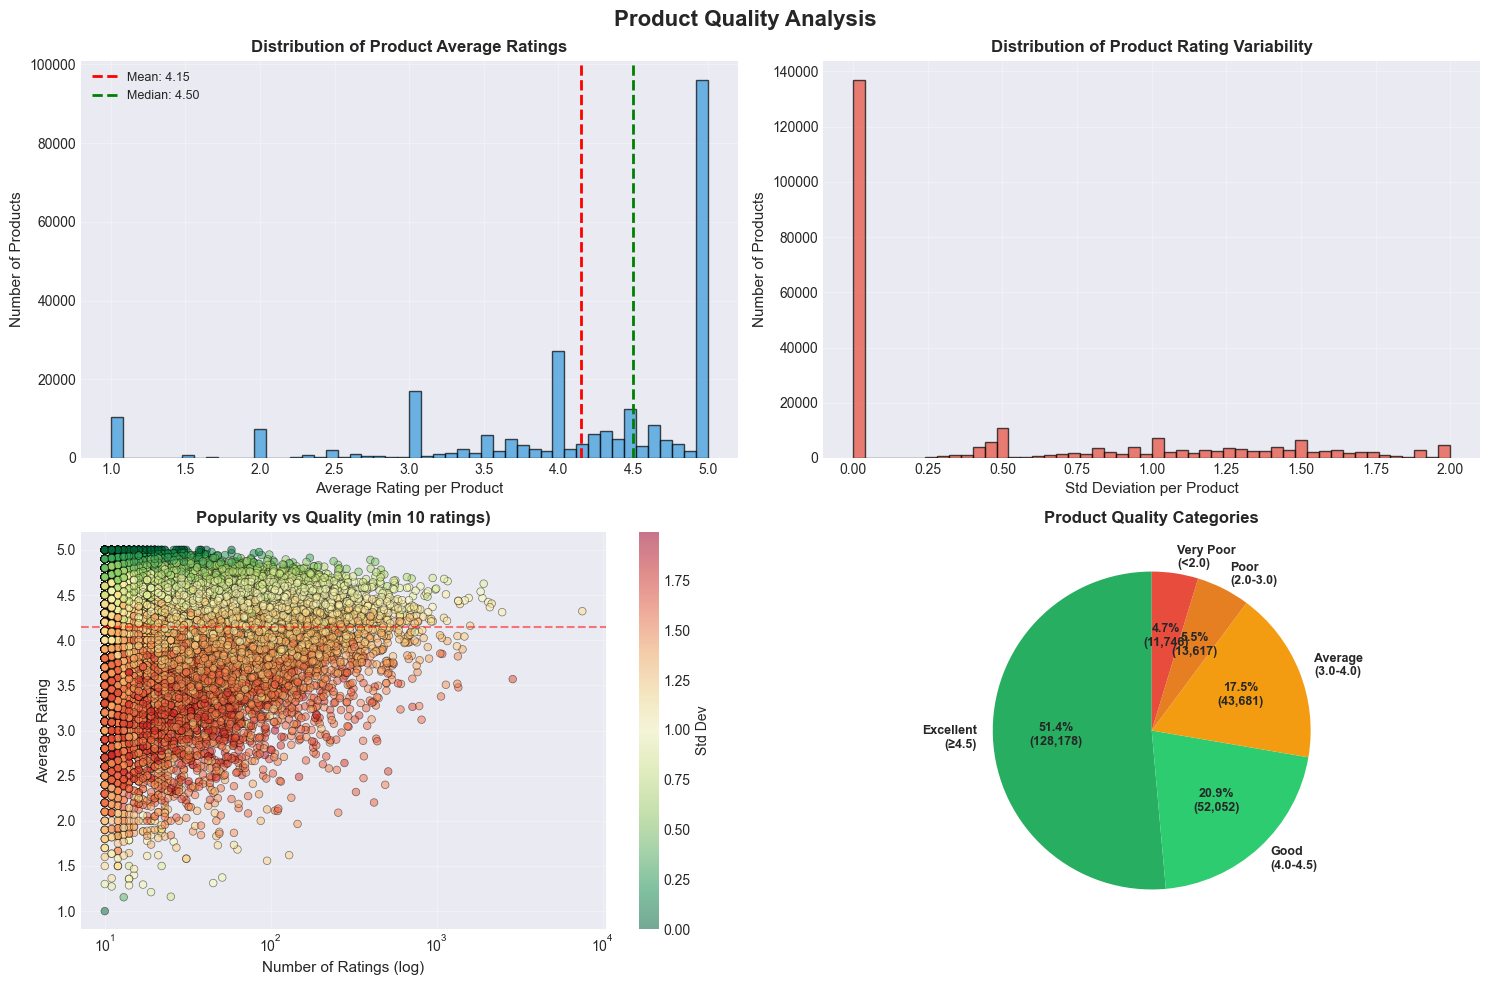

In [96]:
# Visualize product quality
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Product Quality Analysis', fontsize=16, fontweight='bold')

# Distribution of product mean ratings
ax1 = axes[0, 0]
ax1.hist(product_mean_ratings, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(overall_mean_quality, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {overall_mean_quality:.2f}')
ax1.axvline(overall_median_quality, color='green', linestyle='--', linewidth=2,
           label=f'Median: {overall_median_quality:.2f}')
ax1.set_xlabel('Average Rating per Product', fontsize=11)
ax1.set_ylabel('Number of Products', fontsize=11)
ax1.set_title('Distribution of Product Average Ratings', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Distribution of product std
ax2 = axes[0, 1]
ax2.hist(product_std_ratings, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Std Deviation per Product', fontsize=11)
ax2.set_ylabel('Number of Products', fontsize=11)
ax2.set_title('Distribution of Product Rating Variability', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Scatter: Popularity vs Quality
ax3 = axes[1, 0]
eligible_mask = product_n_ratings >= 10
if np.sum(eligible_mask) > 0:
    eligible_counts = product_n_ratings[eligible_mask]
    eligible_means = product_mean_ratings[eligible_mask]
    eligible_stds = product_std_ratings[eligible_mask]
    
    scatter = ax3.scatter(eligible_counts, eligible_means, 
                         alpha=0.5, s=30, c=eligible_stds, cmap='RdYlGn_r',
                         edgecolors='black', linewidth=0.5)
    ax3.set_xscale('log')
    ax3.set_xlabel('Number of Ratings (log)', fontsize=11)
    ax3.set_ylabel('Average Rating', fontsize=11)
    ax3.set_title('Popularity vs Quality (min 10 ratings)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(overall_mean_quality, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    plt.colorbar(scatter, ax=ax3, label='Std Dev')

# Quality categories pie chart
ax4 = axes[1, 1]
quality_names = ['Excellent\n(≥4.5)', 'Good\n(4.0-4.5)', 'Average\n(3.0-4.0)', 
                 'Poor\n(2.0-3.0)', 'Very Poor\n(<2.0)']
quality_counts = np.array([excellent, good, average, poor, very_poor])
quality_colors = ['#27ae60', '#2ecc71', '#f39c12', '#e67e22', '#e74c3c']

# Filter non-zero
non_zero_mask = quality_counts > 0
filtered_names = [name for name, count in zip(quality_names, quality_counts) if count > 0]
filtered_counts = quality_counts[non_zero_mask]
filtered_colors = [color for color, count in zip(quality_colors, quality_counts) if count > 0]

ax4.pie(filtered_counts, labels=filtered_names,
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*n_products_total):,})',
        colors=filtered_colors, startangle=90,
        textprops={'fontsize': 9, 'weight': 'bold'})
ax4.set_title('Product Quality Categories', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Temporal Analysis

Phân tích xu hướng theo thời gian (nếu có timestamp)

9. TEMPORAL ANALYSIS

📅 Timestamp Availability:
----------------------------------------------------------------------
  • Total ratings: 2,023,070
  • Ratings with valid timestamps: 2,023,070 (100.00%)
  • Ratings without timestamps: 0

📊 Temporal Coverage:
----------------------------------------------------------------------
  • First rating: 1998-10-19 07:00:00
  • Last rating: 2014-07-23 07:00:00
  • Time span: 15.76 years

📈 Activity Trends:
----------------------------------------------------------------------
  • Unique months with data: 178
  • Peak month: 201401 with 96,588 ratings
  • Average ratings per month: 11365.56
  • Median ratings per month: 1129.50

🔍 Rating Inflation Analysis:
----------------------------------------------------------------------
  • Average rating (first half): 4.1758
  • Average rating (second half): 4.1489
  • Change: -0.0269
  ✓ Ratings are relatively stable over time.

📅 Yearly Breakdown:
-------------------------------------------------------

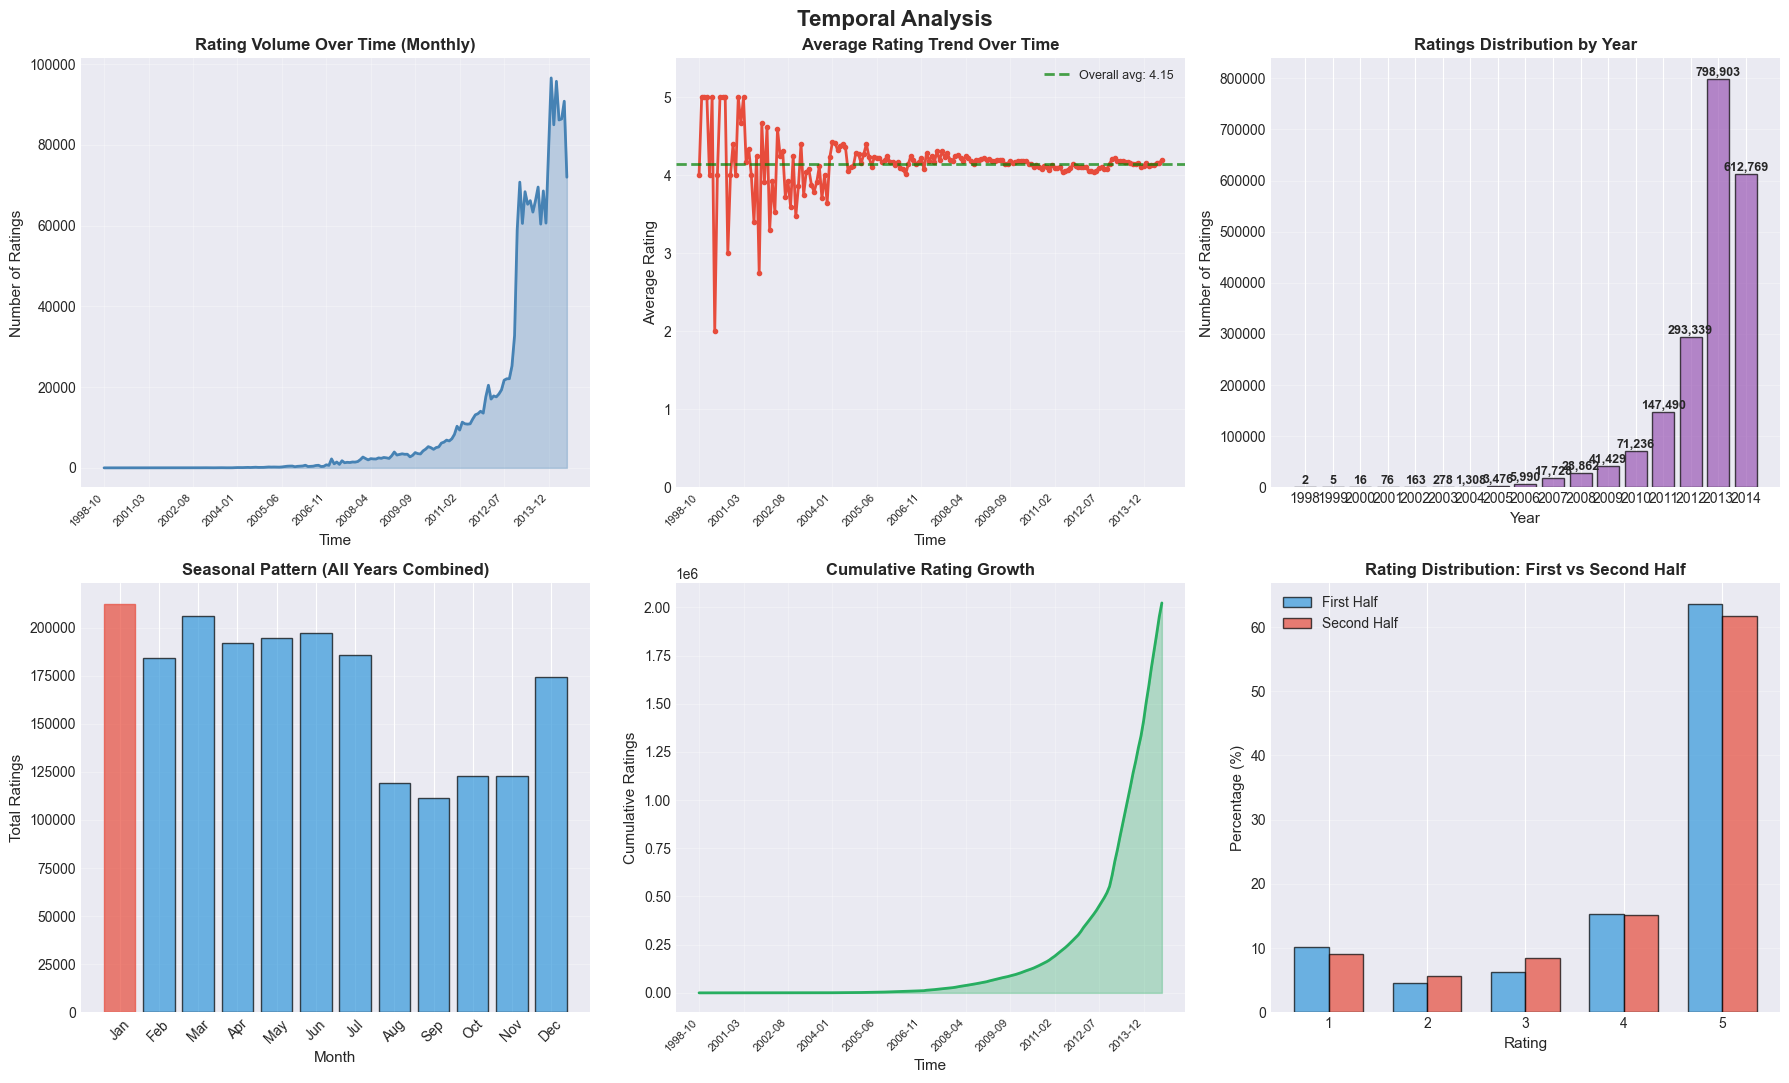


✓ Temporal analysis completed!


In [97]:
print("="*70)
print("9. TEMPORAL ANALYSIS")
print("="*70)

# Extract timestamps column
timestamps = data[:, 3]

# Check if timestamps are available
non_zero_timestamps = np.sum(timestamps > 0)
timestamp_availability = (non_zero_timestamps / len(timestamps)) * 100

print(f"\n📅 Timestamp Availability:")
print("-" * 70)
print(f"  • Total ratings: {len(timestamps):,}")
print(f"  • Ratings with valid timestamps: {non_zero_timestamps:,} ({timestamp_availability:.2f}%)")
print(f"  • Ratings without timestamps: {len(timestamps) - non_zero_timestamps:,}")

if non_zero_timestamps > 0:
    # Filter ratings with valid timestamps
    valid_timestamp_mask = timestamps > 0
    valid_timestamps = timestamps[valid_timestamp_mask]
    valid_ratings = ratings[valid_timestamp_mask]
    
    # Convert timestamps to datetime
    from datetime import datetime
    
    # Find timestamp range
    min_timestamp = int(np.min(valid_timestamps))
    max_timestamp = int(np.max(valid_timestamps))
    
    min_date = datetime.fromtimestamp(min_timestamp)
    max_date = datetime.fromtimestamp(max_timestamp)
    
    print(f"\n📊 Temporal Coverage:")
    print("-" * 70)
    print(f"  • First rating: {min_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"  • Last rating: {max_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"  • Time span: {(max_timestamp - min_timestamp) / (365.25 * 24 * 3600):.2f} years")
    
    # Convert timestamps to years and months for aggregation
    dates = np.array([datetime.fromtimestamp(int(ts)) for ts in valid_timestamps])
    years = np.array([d.year for d in dates])
    months = np.array([d.month for d in dates])
    year_months = np.array([d.year * 100 + d.month for d in dates])  # YYYYMM format
    
    # 1. Ratings count over time (by month)
    unique_year_months = np.unique(year_months)
    monthly_counts = np.array([np.sum(year_months == ym) for ym in unique_year_months])
    
    # 2. Average rating over time (by month)
    monthly_avg_ratings = np.array([np.mean(valid_ratings[year_months == ym]) for ym in unique_year_months])
    
    print(f"\n📈 Activity Trends:")
    print("-" * 70)
    print(f"  • Unique months with data: {len(unique_year_months)}")
    print(f"  • Peak month: {unique_year_months[np.argmax(monthly_counts)]} with {np.max(monthly_counts):,} ratings")
    print(f"  • Average ratings per month: {np.mean(monthly_counts):.2f}")
    print(f"  • Median ratings per month: {np.median(monthly_counts):.2f}")
    
    # 3. Rating inflation analysis
    first_half_mask = valid_timestamps < (min_timestamp + (max_timestamp - min_timestamp) / 2)
    second_half_mask = ~first_half_mask
    
    first_half_avg = np.mean(valid_ratings[first_half_mask])
    second_half_avg = np.mean(valid_ratings[second_half_mask])
    rating_change = second_half_avg - first_half_avg
    
    print(f"\n🔍 Rating Inflation Analysis:")
    print("-" * 70)
    print(f"  • Average rating (first half): {first_half_avg:.4f}")
    print(f"  • Average rating (second half): {second_half_avg:.4f}")
    print(f"  • Change: {rating_change:+.4f}")
    
    if abs(rating_change) > 0.1:
        if rating_change > 0:
            print("  ⚠ Rating inflation detected! Ratings increased over time.")
        else:
            print("  ⚠ Rating deflation detected! Ratings decreased over time.")
    else:
        print("  ✓ Ratings are relatively stable over time.")
    
    # 4. Yearly analysis
    unique_years = np.unique(years)
    yearly_counts = np.array([np.sum(years == y) for y in unique_years])
    yearly_avg_ratings = np.array([np.mean(valid_ratings[years == y]) for y in unique_years])
    
    print(f"\n📅 Yearly Breakdown:")
    print("-" * 70)
    print(f"{'Year':<8} {'# Ratings':<15} {'Avg Rating':<15} {'% of Total'}")
    print("-" * 70)
    for year, count, avg_rating in zip(unique_years, yearly_counts, yearly_avg_ratings):
        pct = (count / len(valid_timestamps)) * 100
        print(f"{int(year):<8} {count:<15,} {avg_rating:<15.4f} {pct:.2f}%")
    
    # 5. Seasonal patterns (monthly aggregation)
    monthly_distribution = np.array([np.sum(months == m) for m in range(1, 13)])
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    peak_month = np.argmax(monthly_distribution) + 1
    print(f"\n🌡️ Seasonal Patterns:")
    print("-" * 70)
    print(f"  • Peak month: {month_names[peak_month-1]} with {monthly_distribution[peak_month-1]:,} ratings")
    print(f"  • Lowest month: {month_names[np.argmin(monthly_distribution)]} with {np.min(monthly_distribution):,} ratings")
    
    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    fig.suptitle('Temporal Analysis', fontsize=16, fontweight='bold')
    
    # Subplot 1: Ratings count over time (monthly)
    ax1 = axes[0, 0]
    # Convert YYYYMM to readable format for plotting
    month_labels = [f"{ym//100}-{ym%100:02d}" for ym in unique_year_months]
    # Plot every Nth label to avoid crowding
    label_step = max(1, len(month_labels) // 10)
    x_indices = np.arange(len(monthly_counts))
    
    ax1.plot(x_indices, monthly_counts, color='steelblue', linewidth=2)
    ax1.fill_between(x_indices, monthly_counts, alpha=0.3, color='steelblue')
    ax1.set_xlabel('Time', fontsize=11)
    ax1.set_ylabel('Number of Ratings', fontsize=11)
    ax1.set_title('Rating Volume Over Time (Monthly)', fontsize=12, fontweight='bold')
    ax1.set_xticks(x_indices[::label_step])
    ax1.set_xticklabels(month_labels[::label_step], rotation=45, ha='right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Average rating over time (monthly)
    ax2 = axes[0, 1]
    ax2.plot(x_indices, monthly_avg_ratings, color='#e74c3c', linewidth=2, marker='o', markersize=3)
    ax2.axhline(np.mean(valid_ratings), color='green', linestyle='--', linewidth=2, 
               label=f'Overall avg: {np.mean(valid_ratings):.2f}', alpha=0.7)
    ax2.set_xlabel('Time', fontsize=11)
    ax2.set_ylabel('Average Rating', fontsize=11)
    ax2.set_title('Average Rating Trend Over Time', fontsize=12, fontweight='bold')
    ax2.set_xticks(x_indices[::label_step])
    ax2.set_xticklabels(month_labels[::label_step], rotation=45, ha='right', fontsize=8)
    ax2.set_ylim([0, 5.5])
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Yearly distribution
    ax3 = axes[0, 2]
    bars = ax3.bar(unique_years.astype(str), yearly_counts, color='#9b59b6', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Year', fontsize=11)
    ax3.set_ylabel('Number of Ratings', fontsize=11)
    ax3.set_title('Ratings Distribution by Year', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, count in zip(bars, yearly_counts):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Subplot 4: Seasonal patterns (monthly distribution)
    ax4 = axes[1, 0]
    bars4 = ax4.bar(month_names, monthly_distribution, color='#3498db', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Month', fontsize=11)
    ax4.set_ylabel('Total Ratings', fontsize=11)
    ax4.set_title('Seasonal Pattern (All Years Combined)', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Highlight peak month
    bars4[peak_month-1].set_color('#e74c3c')
    
    # Subplot 5: Cumulative ratings over time
    ax5 = axes[1, 1]
    cumulative_counts = np.cumsum(monthly_counts)
    ax5.plot(x_indices, cumulative_counts, color='#27ae60', linewidth=2)
    ax5.fill_between(x_indices, cumulative_counts, alpha=0.3, color='#27ae60')
    ax5.set_xlabel('Time', fontsize=11)
    ax5.set_ylabel('Cumulative Ratings', fontsize=11)
    ax5.set_title('Cumulative Rating Growth', fontsize=12, fontweight='bold')
    ax5.set_xticks(x_indices[::label_step])
    ax5.set_xticklabels(month_labels[::label_step], rotation=45, ha='right', fontsize=8)
    ax5.grid(True, alpha=0.3)
    
    # Subplot 6: Rating distribution comparison (first vs second half)
    ax6 = axes[1, 2]
    first_half_ratings = valid_ratings[first_half_mask]
    second_half_ratings = valid_ratings[second_half_mask]
    
    rating_values = [1, 2, 3, 4, 5]
    first_half_dist = [np.sum(first_half_ratings == r) / len(first_half_ratings) * 100 for r in rating_values]
    second_half_dist = [np.sum(second_half_ratings == r) / len(second_half_ratings) * 100 for r in rating_values]
    
    x = np.arange(len(rating_values))
    width = 0.35
    
    bars1 = ax6.bar(x - width/2, first_half_dist, width, label='First Half', 
                    color='#3498db', alpha=0.7, edgecolor='black')
    bars2 = ax6.bar(x + width/2, second_half_dist, width, label='Second Half', 
                    color='#e74c3c', alpha=0.7, edgecolor='black')
    
    ax6.set_xlabel('Rating', fontsize=11)
    ax6.set_ylabel('Percentage (%)', fontsize=11)
    ax6.set_title('Rating Distribution: First vs Second Half', fontsize=12, fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(rating_values)
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Temporal analysis completed!")
    
else:
    print("\n⚠ No valid timestamps available for temporal analysis.")
    print("Skipping temporal visualizations.")


## 10. Data Sparsity Analysis

Phân tích độ thưa của dữ liệu - quan trọng cho recommendation systems!

10. DATA SPARSITY ANALYSIS

📊 User-Item Matrix Dimensions:
----------------------------------------------------------------------
  • Number of users: 1,210,271
  • Number of products: 249,274
  • Matrix size: 1,210,271 × 249,274
  • Total possible ratings: 301,689,093,254

🕳️ Sparsity Metrics:
----------------------------------------------------------------------
  • Actual ratings: 2,023,070
  • Sparsity: 0.99999329 (99.999329%)
  • Density: 0.00067058%
  • Fill ratio: 1 in 149,124 entries
  ⚠ Extremely sparse matrix! Collaborative filtering will be challenging.

📈 Coverage Statistics:
----------------------------------------------------------------------
  • User coverage: 100.00% (1,210,271/1,210,271)
  • Product coverage: 100.00% (249,274/249,274)

📊 Non-zero Entries Distribution:
----------------------------------------------------------------------
  • Avg ratings per user: 1.67
  • Median ratings per user: 1.0
  • Max ratings per user: 389
  • Avg ratings per product: 8.12
  • 

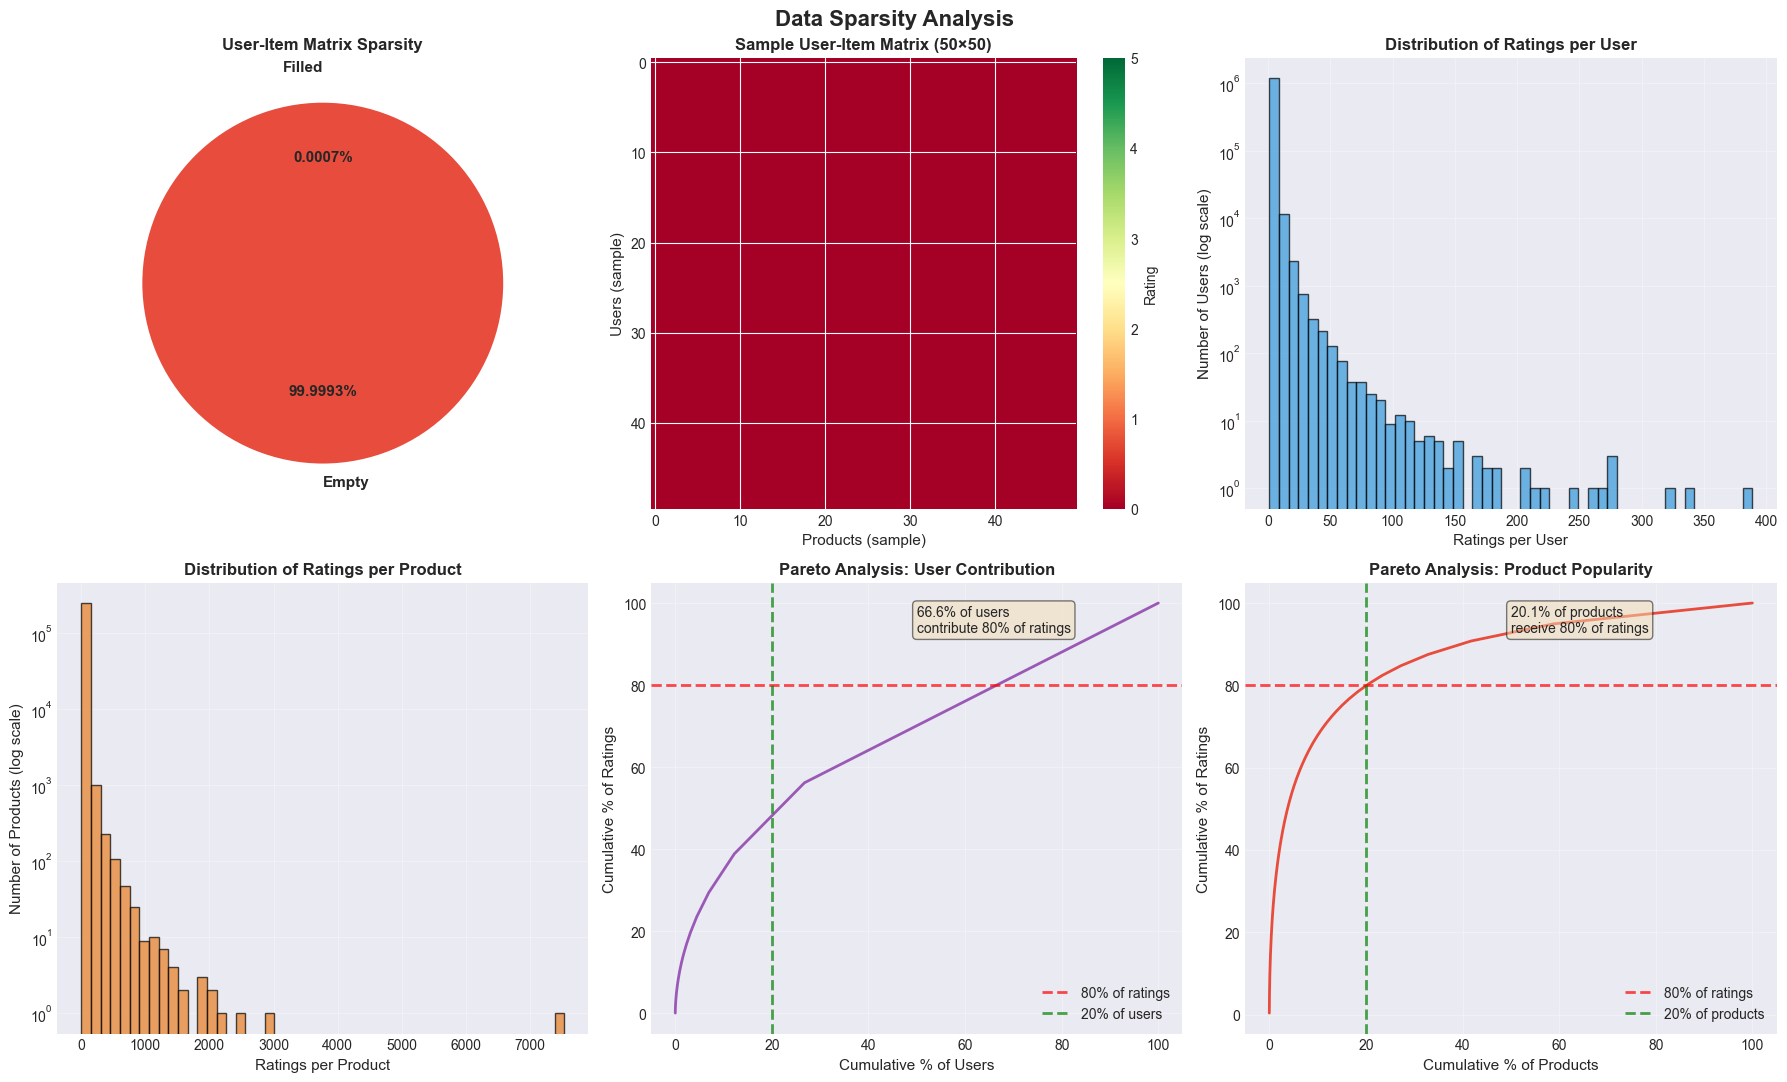


✓ Data sparsity analysis completed!


In [98]:
print("="*70)
print("10. DATA SPARSITY ANALYSIS")
print("="*70)

# Get dimensions of user-item matrix
n_users = len(np.unique(user_ids))
n_products = len(np.unique(product_ids))
n_ratings = len(ratings)

# Calculate sparsity
total_possible_ratings = n_users * n_products
sparsity = 1 - (n_ratings / total_possible_ratings)
density = (n_ratings / total_possible_ratings) * 100

print(f"\n📊 User-Item Matrix Dimensions:")
print("-" * 70)
print(f"  • Number of users: {n_users:,}")
print(f"  • Number of products: {n_products:,}")
print(f"  • Matrix size: {n_users:,} × {n_products:,}")
print(f"  • Total possible ratings: {total_possible_ratings:,}")

print(f"\n🕳️ Sparsity Metrics:")
print("-" * 70)
print(f"  • Actual ratings: {n_ratings:,}")
print(f"  • Sparsity: {sparsity:.8f} ({sparsity*100:.6f}%)")
print(f"  • Density: {density:.8f}%")
print(f"  • Fill ratio: 1 in {int(1/density*100):,} entries")

if sparsity > 0.99:
    print("  ⚠ Extremely sparse matrix! Collaborative filtering will be challenging.")
elif sparsity > 0.95:
    print("  ⚠ Very sparse matrix. Matrix factorization recommended.")
else:
    print("  ✓ Moderate sparsity. Standard CF algorithms should work well.")

# Calculate coverage metrics
users_with_ratings = n_users  # All users have at least 1 rating (by definition)
products_with_ratings = n_products  # All products have at least 1 rating

user_coverage = (users_with_ratings / n_users) * 100
product_coverage = (products_with_ratings / n_products) * 100

print(f"\n📈 Coverage Statistics:")
print("-" * 70)
print(f"  • User coverage: {user_coverage:.2f}% ({users_with_ratings:,}/{n_users:,})")
print(f"  • Product coverage: {product_coverage:.2f}% ({products_with_ratings:,}/{n_products:,})")

# Analyze distribution of non-zero entries per user and product
# Use the already calculated user_rating_counts and product_rating_counts
print(f"\n📊 Non-zero Entries Distribution:")
print("-" * 70)
print(f"  • Avg ratings per user: {np.mean(user_rating_counts):.2f}")
print(f"  • Median ratings per user: {np.median(user_rating_counts):.1f}")
print(f"  • Max ratings per user: {np.max(user_rating_counts):,}")
print(f"  • Avg ratings per product: {np.mean(product_rating_counts):.2f}")
print(f"  • Median ratings per product: {np.median(product_rating_counts):.1f}")
print(f"  • Max ratings per product: {np.max(product_rating_counts):,}")

# Calculate percentiles for better understanding
user_percentiles = np.percentile(user_rating_counts, [25, 50, 75, 90, 95, 99])
product_percentiles = np.percentile(product_rating_counts, [25, 50, 75, 90, 95, 99])

print(f"\n📊 Rating Distribution Percentiles:")
print("-" * 70)
print(f"{'Percentile':<12} {'Users':<15} {'Products':<15}")
print("-" * 70)
for pct, u_val, p_val in zip([25, 50, 75, 90, 95, 99], user_percentiles, product_percentiles):
    print(f"{pct}th{'':<9} {u_val:<15.1f} {p_val:<15.1f}")

# Implications for recommendation systems
print(f"\n🎯 Implications for Recommendation Systems:")
print("-" * 70)

# Long tail analysis
users_top_10_pct = np.sum(user_rating_counts >= np.percentile(user_rating_counts, 90))
ratings_by_top_users = np.sum(user_rating_counts[user_rating_counts >= np.percentile(user_rating_counts, 90)])
pct_ratings_by_top = (ratings_by_top_users / n_ratings) * 100

print(f"  • Top 10% most active users: {users_top_10_pct:,} ({(users_top_10_pct/n_users)*100:.2f}%)")
print(f"  • They contribute: {ratings_by_top_users:,} ratings ({pct_ratings_by_top:.2f}%)")

products_top_10_pct = np.sum(product_rating_counts >= np.percentile(product_rating_counts, 90))
ratings_for_top_products = np.sum(product_rating_counts[product_rating_counts >= np.percentile(product_rating_counts, 90)])
pct_ratings_for_top = (ratings_for_top_products / n_ratings) * 100

print(f"  • Top 10% most popular products: {products_top_10_pct:,} ({(products_top_10_pct/n_products)*100:.2f}%)")
print(f"  • They receive: {ratings_for_top_products:,} ratings ({pct_ratings_for_top:.2f}%)")

# Recommendation strategies
print(f"\n💡 Recommended Strategies:")
print("-" * 70)
if sparsity > 0.999:
    print("  • Use Matrix Factorization (SVD, ALS)")
    print("  • Implement Content-Based Filtering")
    print("  • Consider Hybrid Approaches")
    print("  • Use Popularity-Based for cold start")
elif sparsity > 0.99:
    print("  • Matrix Factorization is highly recommended")
    print("  • Item-based CF may work better than user-based")
    print("  • Consider dimensionality reduction")
else:
    print("  • Both user-based and item-based CF viable")
    print("  • Matrix factorization will improve performance")
    print("  • Neighborhood-based methods should work")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.suptitle('Data Sparsity Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Sparsity visualization
ax1 = axes[0, 0]
categories = ['Filled', 'Empty']
values = [n_ratings, total_possible_ratings - n_ratings]
colors = ['#27ae60', '#e74c3c']
explode = [0.1, 0]

wedges, texts, autotexts = ax1.pie(values, labels=categories, autopct='%1.4f%%',
                                     colors=colors, explode=explode, startangle=90,
                                     textprops={'fontsize': 11, 'weight': 'bold'})
ax1.set_title('User-Item Matrix Sparsity', fontsize=12, fontweight='bold')

# Subplot 2: Sample heatmap (small subset)
ax2 = axes[0, 1]
# Create a small sample matrix for visualization
sample_size_users = min(50, n_users)
sample_size_products = min(50, n_products)

# Randomly sample users and products
sampled_user_indices = np.random.choice(n_users, sample_size_users, replace=False)
sampled_product_indices = np.random.choice(n_products, sample_size_products, replace=False)

# Get unique users and products for indexing
unique_users_array = np.unique(user_ids)
unique_products_array = np.unique(product_ids)

sampled_users = unique_users_array[sampled_user_indices]
sampled_products = unique_products_array[sampled_product_indices]

# Create sample matrix
sample_matrix = np.zeros((sample_size_users, sample_size_products))

for i, user in enumerate(sampled_users):
    user_mask = user_ids == user
    user_products = product_ids[user_mask]
    user_ratings = ratings[user_mask]
    
    for j, product in enumerate(sampled_products):
        product_mask = user_products == product
        if np.any(product_mask):
            sample_matrix[i, j] = user_ratings[product_mask][0]

# Plot heatmap
im = ax2.imshow(sample_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=5)
ax2.set_xlabel('Products (sample)', fontsize=11)
ax2.set_ylabel('Users (sample)', fontsize=11)
ax2.set_title(f'Sample User-Item Matrix ({sample_size_users}×{sample_size_products})', 
             fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax2, label='Rating')

# Subplot 3: Ratings per user distribution (log scale)
ax3 = axes[0, 2]
ax3.hist(user_rating_counts, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Ratings per User', fontsize=11)
ax3.set_ylabel('Number of Users (log scale)', fontsize=11)
ax3.set_yscale('log')
ax3.set_title('Distribution of Ratings per User', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Subplot 4: Ratings per product distribution (log scale)
ax4 = axes[1, 0]
ax4.hist(product_rating_counts, bins=50, color='#e67e22', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Ratings per Product', fontsize=11)
ax4.set_ylabel('Number of Products (log scale)', fontsize=11)
ax4.set_yscale('log')
ax4.set_title('Distribution of Ratings per Product', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Subplot 5: Cumulative distribution of user ratings
ax5 = axes[1, 1]
sorted_user_counts = np.sort(user_rating_counts)[::-1]
cumulative_pct = np.cumsum(sorted_user_counts) / np.sum(sorted_user_counts) * 100
user_pct = np.arange(1, len(sorted_user_counts) + 1) / len(sorted_user_counts) * 100

ax5.plot(user_pct, cumulative_pct, color='#9b59b6', linewidth=2)
ax5.axhline(80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% of ratings')
ax5.axvline(20, color='green', linestyle='--', linewidth=2, alpha=0.7, label='20% of users')
ax5.set_xlabel('Cumulative % of Users', fontsize=11)
ax5.set_ylabel('Cumulative % of Ratings', fontsize=11)
ax5.set_title('Pareto Analysis: User Contribution', fontsize=12, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# Find the % of users contributing 80% of ratings
users_for_80_pct = np.searchsorted(cumulative_pct, 80) / len(cumulative_pct) * 100
ax5.text(0.5, 0.95, f'{users_for_80_pct:.1f}% of users\ncontribute 80% of ratings', 
        transform=ax5.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Subplot 6: Cumulative distribution of product ratings
ax6 = axes[1, 2]
sorted_product_counts = np.sort(product_rating_counts)[::-1]
cumulative_pct_products = np.cumsum(sorted_product_counts) / np.sum(sorted_product_counts) * 100
product_pct = np.arange(1, len(sorted_product_counts) + 1) / len(sorted_product_counts) * 100

ax6.plot(product_pct, cumulative_pct_products, color='#e74c3c', linewidth=2)
ax6.axhline(80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% of ratings')
ax6.axvline(20, color='green', linestyle='--', linewidth=2, alpha=0.7, label='20% of products')
ax6.set_xlabel('Cumulative % of Products', fontsize=11)
ax6.set_ylabel('Cumulative % of Ratings', fontsize=11)
ax6.set_title('Pareto Analysis: Product Popularity', fontsize=12, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

# Find the % of products receiving 80% of ratings
products_for_80_pct = np.searchsorted(cumulative_pct_products, 80) / len(cumulative_pct_products) * 100
ax6.text(0.5, 0.95, f'{products_for_80_pct:.1f}% of products\nreceive 80% of ratings', 
        transform=ax6.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✓ Data sparsity analysis completed!")


## 11. Exploratory Questions

Đặt và trả lời các câu hỏi về dữ liệu

### Câu hỏi 1: Có hiện tượng rating polarization không?

Người dùng có xu hướng cho điểm cực cao (5 sao) hoặc cực thấp (1 sao), ít cho điểm trung bình?

📊 Rating Polarization Analysis:
----------------------------------------------------------------------

Rating Distribution:
  1.0 stars: 183,784 (9.08%) ████
  2.0 stars: 113,034 (5.59%) ██
  3.0 stars: 169,791 (8.39%) ████
  4.0 stars: 307,740 (15.21%) ███████
  5.0 stars: 1,248,721 (61.72%) ██████████████████████████████

🔍 Polarization Metrics:
----------------------------------------------------------------------
  Extreme ratings (1 & 5 stars): 1,432,505 (70.81%)
  Middle ratings (2, 3, 4 stars): 590,565 (29.19%)

📈 Individual Ratings Breakdown:
----------------------------------------------------------------------
  1 star:  183,784 (9.08%)
  2 stars: 113,034 (5.59%)
  3 stars: 169,791 (8.39%)
  4 stars: 307,740 (15.21%)
  5 stars: 1,248,721 (61.72%)

✅ POLARIZATION DETECTED:
   Users prefer extreme ratings (70.81%) over middle ratings (29.19%)
   Polarization ratio: 2.43x


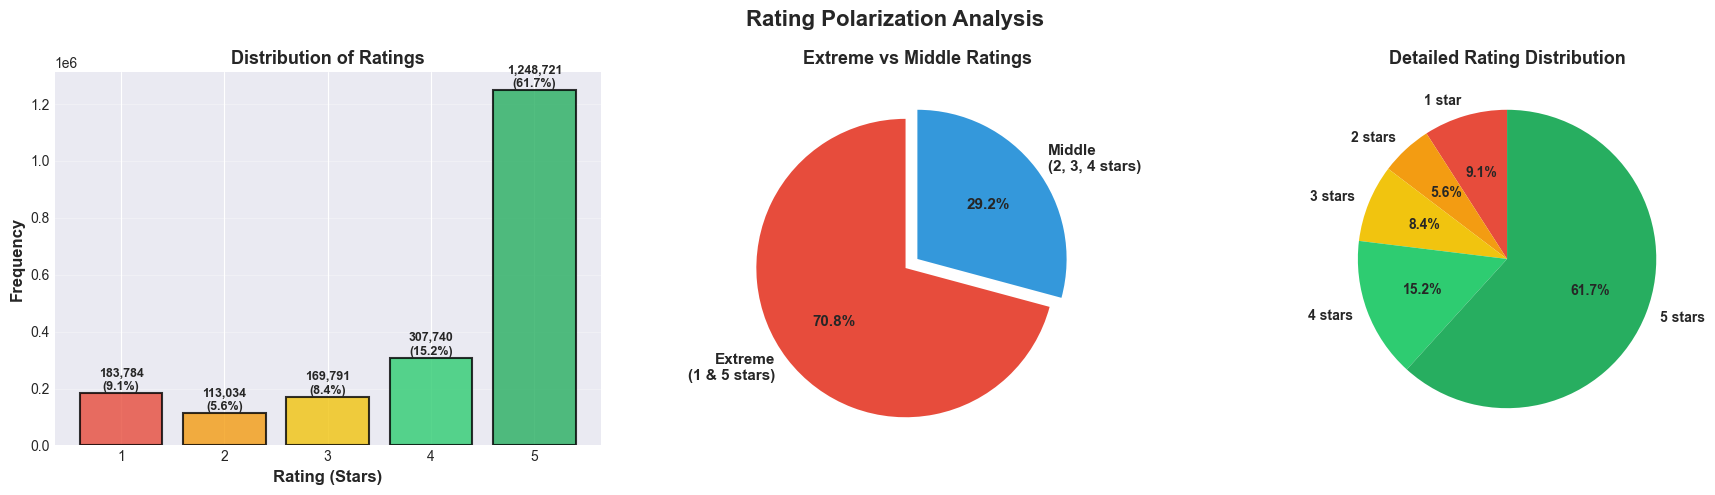


✓ Question 1 completed: Rating polarization analysis done!


In [5]:
# Analyze rating polarization
# Extract ratings from data
ratings = data[:, 2]

# Count frequency of each rating
unique_ratings, counts = np.unique(ratings, return_counts=True)

# Separate extreme ratings (1, 5) from middle ratings (2, 3, 4)
extreme_mask = (ratings == 1.0) | (ratings == 5.0)
middle_mask = (ratings >= 2.0) & (ratings <= 4.0)

extreme_count = np.sum(extreme_mask)
middle_count = np.sum(middle_mask)
total_count = len(ratings)

extreme_pct = (extreme_count / total_count) * 100
middle_pct = (middle_count / total_count) * 100

print(f"📊 Rating Polarization Analysis:")
print("-" * 70)
print(f"\nRating Distribution:")
for rating, count in zip(unique_ratings, counts):
    pct = (count / total_count) * 100
    bar = '█' * int(pct / 2)
    print(f"  {rating:.1f} stars: {count:,} ({pct:.2f}%) {bar}")

print(f"\n🔍 Polarization Metrics:")
print("-" * 70)
print(f"  Extreme ratings (1 & 5 stars): {extreme_count:,} ({extreme_pct:.2f}%)")
print(f"  Middle ratings (2, 3, 4 stars): {middle_count:,} ({middle_pct:.2f}%)")

# Calculate individual star percentages
rating_1_count = np.sum(ratings == 1.0)
rating_2_count = np.sum(ratings == 2.0)
rating_3_count = np.sum(ratings == 3.0)
rating_4_count = np.sum(ratings == 4.0)
rating_5_count = np.sum(ratings == 5.0)

rating_1_pct = (rating_1_count / total_count) * 100
rating_2_pct = (rating_2_count / total_count) * 100
rating_3_pct = (rating_3_count / total_count) * 100
rating_4_pct = (rating_4_count / total_count) * 100
rating_5_pct = (rating_5_count / total_count) * 100

print(f"\n📈 Individual Ratings Breakdown:")
print("-" * 70)
print(f"  1 star:  {rating_1_count:,} ({rating_1_pct:.2f}%)")
print(f"  2 stars: {rating_2_count:,} ({rating_2_pct:.2f}%)")
print(f"  3 stars: {rating_3_count:,} ({rating_3_pct:.2f}%)")
print(f"  4 stars: {rating_4_count:,} ({rating_4_pct:.2f}%)")
print(f"  5 stars: {rating_5_count:,} ({rating_5_pct:.2f}%)")

# Analyze polarization
if extreme_pct > middle_pct:
    print(f"\n✅ POLARIZATION DETECTED:")
    print(f"   Users prefer extreme ratings ({extreme_pct:.2f}%) over middle ratings ({middle_pct:.2f}%)")
    print(f"   Polarization ratio: {extreme_pct/middle_pct:.2f}x")
else:
    print(f"\n❌ NO STRONG POLARIZATION:")
    print(f"   Middle ratings ({middle_pct:.2f}%) are more common than extreme ratings ({extreme_pct:.2f}%)")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Rating Polarization Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Bar chart of rating distribution
ax1 = axes[0]
colors = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60']
bars = ax1.bar(unique_ratings, counts, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Rating (Stars)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Ratings', fontsize=13, fontweight='bold')
ax1.set_xticks(unique_ratings)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/total_count*100:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Subplot 2: Pie chart - Extreme vs Middle
ax2 = axes[1]
polarization_labels = ['Extreme\n(1 & 5 stars)', 'Middle\n(2, 3, 4 stars)']
polarization_values = [extreme_count, middle_count]
polarization_colors = ['#e74c3c', '#3498db']
explode = [0.1, 0]

wedges, texts, autotexts = ax2.pie(polarization_values, labels=polarization_labels, 
                                     autopct='%1.1f%%', colors=polarization_colors,
                                     explode=explode, startangle=90,
                                     textprops={'fontsize': 11, 'weight': 'bold'})
ax2.set_title('Extreme vs Middle Ratings', fontsize=13, fontweight='bold')

# Subplot 3: Detailed pie chart by rating
ax3 = axes[2]
detailed_labels = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
detailed_values = [rating_1_count, rating_2_count, rating_3_count, rating_4_count, rating_5_count]
detailed_colors = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60']

wedges, texts, autotexts = ax3.pie(detailed_values, labels=detailed_labels,
                                     autopct='%1.1f%%', colors=detailed_colors,
                                     startangle=90,
                                     textprops={'fontsize': 10, 'weight': 'bold'})
ax3.set_title('Detailed Rating Distribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Question 1 completed: Rating polarization analysis done!")

### Câu hỏi 2: Sản phẩm nổi bật nhất là gì?

Xác định sản phẩm có sự kết hợp tốt giữa số lượng ratings và chất lượng ratings

📊 Calculating product statistics efficiently...
✓ Statistics calculated for 249,274 products!

📊 Outstanding Products Analysis:
--------------------------------------------------------------------------------

Global Metrics:
  Mean rating across all products: 4.1490
  Median rating count per product: 2.0
  Total products: 249,274

🏆 Top 20 Outstanding Products (by Weighted Rating):
--------------------------------------------------------------------------------
Rank   Product ID      # Ratings    Avg Rating   Weighted Score 
--------------------------------------------------------------------------------
1      53951           58           5.000        4.9716         
2      106321          41           5.000        4.9604         
3      215023          38           5.000        4.9575         
4      24835           38           5.000        4.9575         
5      237275          85           4.976        4.9574         
6      52916           37           5.000        4.9564       

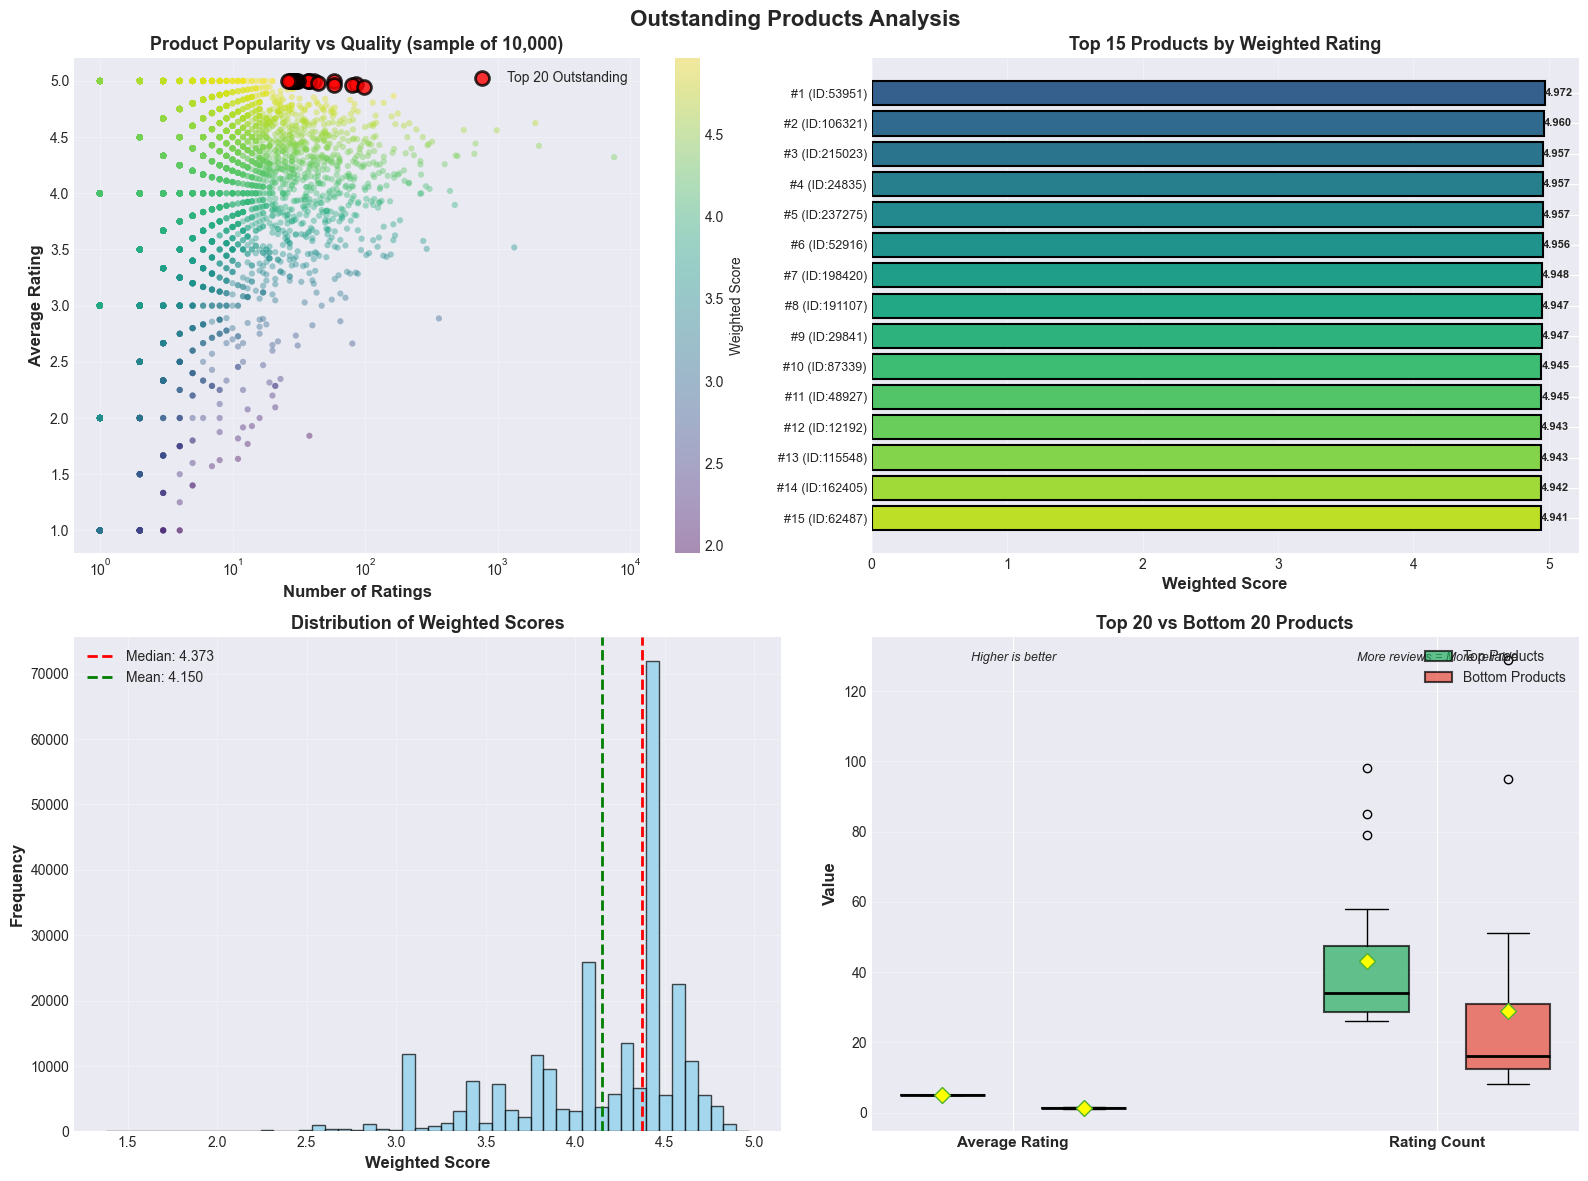


✓ Question 2 completed: Outstanding products identified!


In [8]:
# Find outstanding products using weighted rating formula (highly optimized)
# Extract product IDs and ratings
product_ids = data[:, 1].astype(int)
ratings = data[:, 2]

print(f"📊 Calculating product statistics efficiently...")

# Sort by product_id for efficient grouping
sort_indices = np.argsort(product_ids)
sorted_product_ids = product_ids[sort_indices]
sorted_ratings = ratings[sort_indices]

# Find boundaries where product_id changes
unique_products, first_indices = np.unique(sorted_product_ids, return_index=True)
# Append the total length to get the last boundary
boundaries = np.append(first_indices, len(sorted_product_ids))

# Calculate rating counts and average ratings efficiently
n_products = len(unique_products)
rating_counts = np.diff(boundaries)
avg_ratings = np.array([np.mean(sorted_ratings[boundaries[i]:boundaries[i+1]]) 
                        for i in range(n_products)])

print(f"✓ Statistics calculated for {n_products:,} products!")

# Calculate weighted rating using IMDB formula
# weighted_rating = (v/(v+m)) * R + (m/(v+m)) * C
C = np.mean(ratings)  # Global average rating
m = np.median(rating_counts)  # Minimum votes threshold

# Calculate weighted scores (vectorized)
weighted_scores = (rating_counts / (rating_counts + m)) * avg_ratings + (m / (rating_counts + m)) * C

print(f"\n📊 Outstanding Products Analysis:")
print("-" * 80)
print(f"\nGlobal Metrics:")
print(f"  Mean rating across all products: {C:.4f}")
print(f"  Median rating count per product: {m:.1f}")
print(f"  Total products: {n_products:,}")

# Find top products by weighted score
top_n = 20
top_indices = np.argsort(weighted_scores)[::-1][:top_n]

print(f"\n🏆 Top {top_n} Outstanding Products (by Weighted Rating):")
print("-" * 80)
print(f"{'Rank':<6} {'Product ID':<15} {'# Ratings':<12} {'Avg Rating':<12} {'Weighted Score':<15}")
print("-" * 80)

for rank, idx in enumerate(top_indices, 1):
    pid = unique_products[idx]
    count = rating_counts[idx]
    avg_r = avg_ratings[idx]
    w_score = weighted_scores[idx]
    print(f"{rank:<6} {int(pid):<15} {count:<12} {avg_r:<12.3f} {w_score:<15.4f}")

# Analyze characteristics of top products
top_avg_rating = np.mean(avg_ratings[top_indices])
top_avg_count = np.mean(rating_counts[top_indices])
top_min_count = np.min(rating_counts[top_indices])

print(f"\n📈 Characteristics of Top {top_n} Products:")
print("-" * 80)
print(f"  Average rating: {top_avg_rating:.3f}")
print(f"  Average rating count: {top_avg_count:.1f}")
print(f"  Minimum rating count: {int(top_min_count)}")
print(f"  → Outstanding products have high ratings AND many reviews")

# Compare with products that have highest ratings (but possibly few reviews)
high_rating_mask = avg_ratings >= 4.9
high_rating_products = np.sum(high_rating_mask)
high_rating_avg_count = np.mean(rating_counts[high_rating_mask]) if high_rating_products > 0 else 0

print(f"\n⚠️  Products with Rating ≥ 4.9:")
print(f"  Count: {high_rating_products:,}")
print(f"  Average review count: {high_rating_avg_count:.1f}")
print(f"  → Many high-rated products have few reviews (less reliable)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Outstanding Products Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Scatter plot - Rating Count vs Avg Rating (sample for performance)
ax1 = axes[0, 0]
# Sample products for visualization (too many to plot all)
sample_size = min(10000, n_products)
sample_indices = np.random.choice(n_products, sample_size, replace=False)

scatter = ax1.scatter(rating_counts[sample_indices], avg_ratings[sample_indices], 
                     alpha=0.4, s=20, c=weighted_scores[sample_indices], 
                     cmap='viridis', edgecolors='none')
# Highlight top products
ax1.scatter(rating_counts[top_indices], avg_ratings[top_indices], 
           color='red', s=100, alpha=0.8, edgecolors='black', linewidth=2,
           label=f'Top {top_n} Outstanding', zorder=5)
ax1.set_xlabel('Number of Ratings', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Rating', fontsize=12, fontweight='bold')
ax1.set_title(f'Product Popularity vs Quality (sample of {sample_size:,})', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
plt.colorbar(scatter, ax=ax1, label='Weighted Score')

# Subplot 2: Bar chart - Top 15 products by weighted score
ax2 = axes[0, 1]
top_15_idx = top_indices[:15]
x_pos = np.arange(len(top_15_idx))
colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15_idx)))

bars = ax2.barh(x_pos, weighted_scores[top_15_idx], color=colors_gradient, 
               edgecolor='black', linewidth=1.5)
ax2.set_yticks(x_pos)
ax2.set_yticklabels([f"#{i+1} (ID:{int(unique_products[idx])})" for i, idx in enumerate(top_15_idx)], 
                    fontsize=9)
ax2.set_xlabel('Weighted Score', fontsize=12, fontweight='bold')
ax2.set_title('Top 15 Products by Weighted Rating', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Add value labels
for bar, idx in zip(bars, top_15_idx):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            ha='left', va='center', fontsize=8, fontweight='bold')

# Subplot 3: Distribution of weighted scores
ax3 = axes[1, 0]
ax3.hist(weighted_scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax3.axvline(np.median(weighted_scores), color='red', linestyle='--', 
           linewidth=2, label=f'Median: {np.median(weighted_scores):.3f}')
ax3.axvline(np.mean(weighted_scores), color='green', linestyle='--', 
           linewidth=2, label=f'Mean: {np.mean(weighted_scores):.3f}')
ax3.set_xlabel('Weighted Score', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Distribution of Weighted Scores', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Subplot 4: Comparison - Top vs Bottom products
ax4 = axes[1, 1]
bottom_indices = np.argsort(weighted_scores)[:top_n]

comparison_data = [
    avg_ratings[top_indices],
    avg_ratings[bottom_indices],
    rating_counts[top_indices],
    rating_counts[bottom_indices]
]

box_positions = [1, 2, 4, 5]
box_colors = ['#27ae60', '#e74c3c', '#27ae60', '#e74c3c']

bp = ax4.boxplot(comparison_data, positions=box_positions, widths=0.6,
                patch_artist=True, showmeans=True,
                boxprops=dict(linewidth=1.5),
                medianprops=dict(color='black', linewidth=2),
                meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))

for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax4.set_xticks([1.5, 4.5])
ax4.set_xticklabels(['Average Rating', 'Rating Count'], fontsize=11, fontweight='bold')
ax4.set_ylabel('Value', fontsize=12, fontweight='bold')
ax4.set_title(f'Top {top_n} vs Bottom {top_n} Products', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.legend([bp['boxes'][0], bp['boxes'][1]], ['Top Products', 'Bottom Products'], 
          loc='upper right', fontsize=10)

# Add text annotations
ax4.text(1.5, ax4.get_ylim()[1] * 0.95, 'Higher is better', 
        ha='center', fontsize=9, style='italic')
ax4.text(4.5, ax4.get_ylim()[1] * 0.95, 'More reviews = More reliable', 
        ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.show()

print("\n✓ Question 2 completed: Outstanding products identified!")

### Câu hỏi 3: Có tồn tại "power users" không?

Phân tích sự phân bố hoạt động của users - có một nhóm nhỏ users đóng góp phần lớn ratings?

📊 Analyzing user contribution distribution...
✓ Calculated contributions for 1,210,271 users!

📊 Power Users Analysis:
--------------------------------------------------------------------------------

Overall Statistics:
  Total users: 1,210,271
  Total ratings: 2,023,070
  Average ratings per user: 1.67
  Median ratings per user: 1.0

🎯 Pareto Analysis (Contribution Thresholds):
--------------------------------------------------------------------------------
  21.55% of users contribute 50% of ratings (260,802 users)
  66.57% of users contribute 80% of ratings (805,656 users)
  83.28% of users contribute 90% of ratings (1,007,963 users)

⚠️  MODERATE POWER USER EFFECT
   66.57% of users needed for 80% of ratings
   More distributed than typical power user patterns

👥 User Segmentation:
--------------------------------------------------------------------------------
Segment              Users           Ratings         % of Total      Avg/User
-------------------------------------------

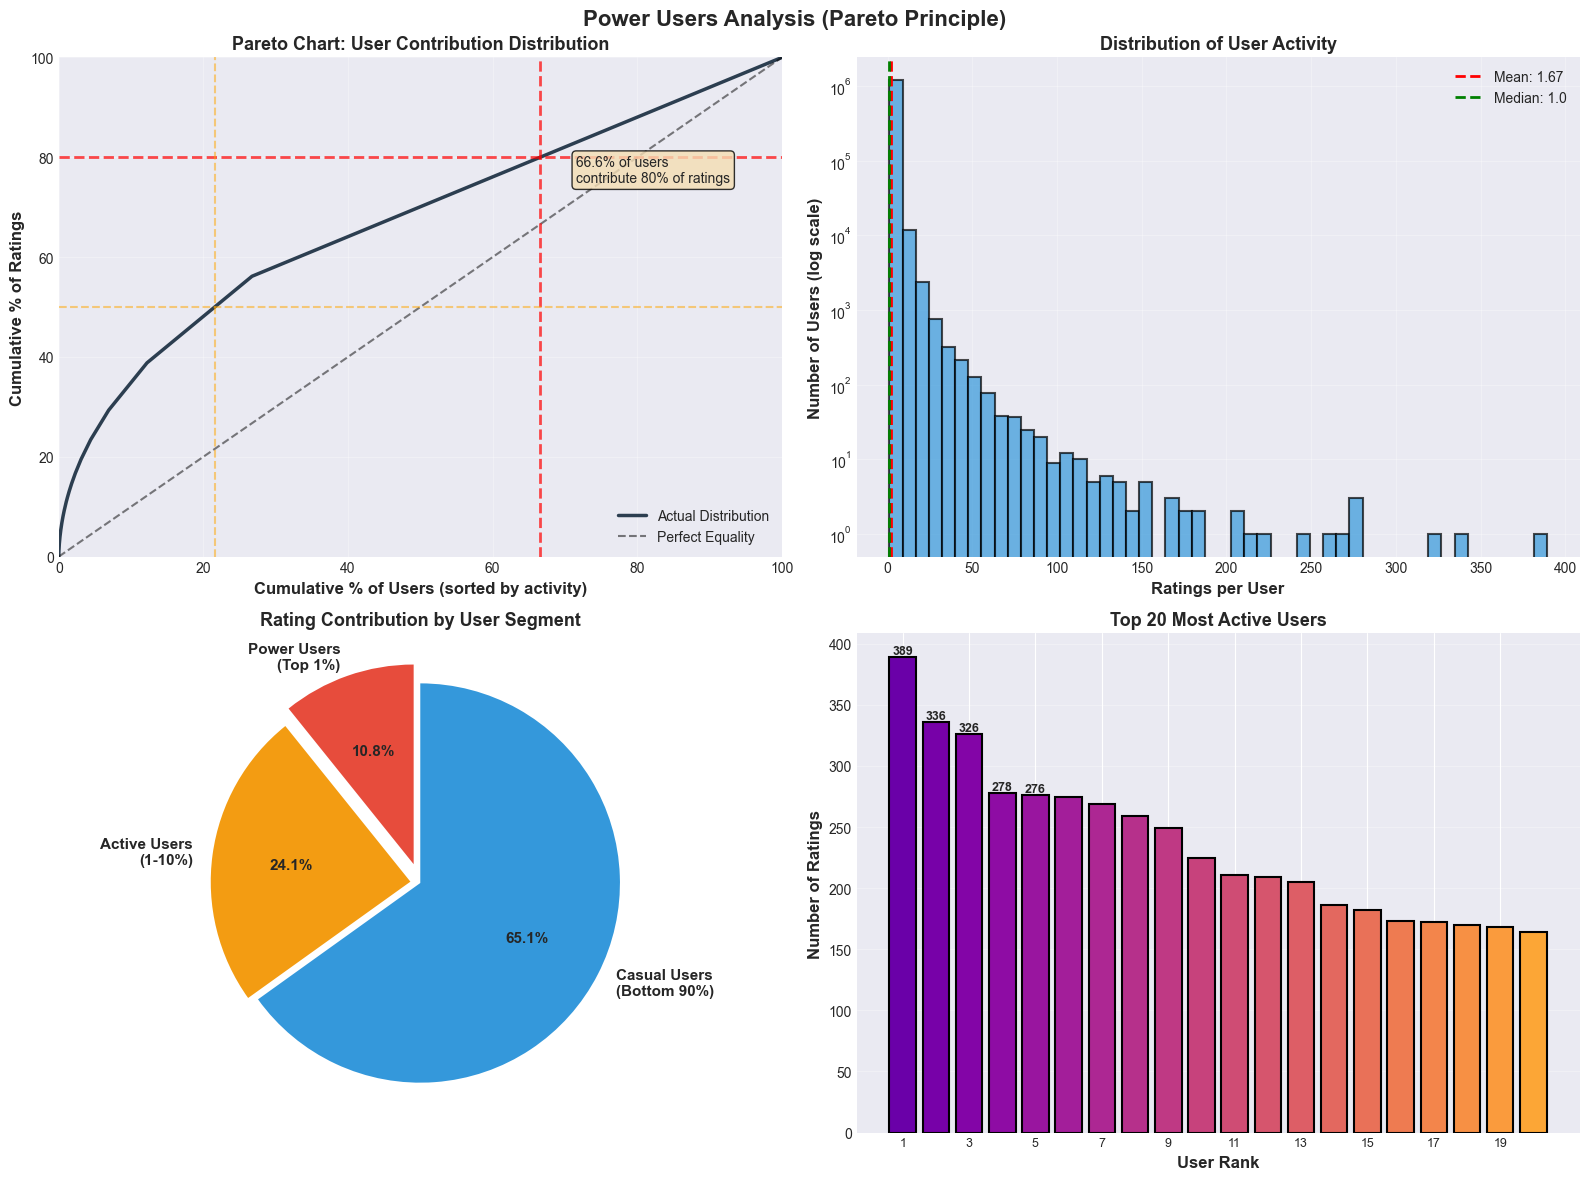


✓ Question 3 completed: Power users analysis done!


In [9]:
# Analyze Power Users - Pareto Analysis (80-20 rule)
# Extract user IDs
user_ids = data[:, 0].astype(int)

print(f"📊 Analyzing user contribution distribution...")

# Sort by user_id for efficient grouping
sort_indices = np.argsort(user_ids)
sorted_user_ids = user_ids[sort_indices]

# Find boundaries where user_id changes
unique_users, first_indices = np.unique(sorted_user_ids, return_index=True)
boundaries = np.append(first_indices, len(sorted_user_ids))

# Calculate rating counts per user efficiently
n_users = len(unique_users)
user_rating_counts = np.diff(boundaries)

print(f"✓ Calculated contributions for {n_users:,} users!")

# Sort users by their rating counts (descending)
sorted_indices = np.argsort(user_rating_counts)[::-1]
sorted_counts = user_rating_counts[sorted_indices]
sorted_user_ids = unique_users[sorted_indices]

# Calculate cumulative statistics
total_ratings = np.sum(user_rating_counts)
cumulative_ratings = np.cumsum(sorted_counts)
cumulative_pct = (cumulative_ratings / total_ratings) * 100
user_cumulative_pct = (np.arange(1, n_users + 1) / n_users) * 100

print(f"\n📊 Power Users Analysis:")
print("-" * 80)
print(f"\nOverall Statistics:")
print(f"  Total users: {n_users:,}")
print(f"  Total ratings: {total_ratings:,}")
print(f"  Average ratings per user: {np.mean(user_rating_counts):.2f}")
print(f"  Median ratings per user: {np.median(user_rating_counts):.1f}")

# Find key thresholds
# What % of users contribute 80% of ratings?
idx_80_ratings = np.searchsorted(cumulative_pct, 80)
pct_users_for_80_ratings = (idx_80_ratings / n_users) * 100
users_for_80 = idx_80_ratings

# What % of users contribute 50% of ratings?
idx_50_ratings = np.searchsorted(cumulative_pct, 50)
pct_users_for_50_ratings = (idx_50_ratings / n_users) * 100

# What % of users contribute 90% of ratings?
idx_90_ratings = np.searchsorted(cumulative_pct, 90)
pct_users_for_90_ratings = (idx_90_ratings / n_users) * 100

print(f"\n🎯 Pareto Analysis (Contribution Thresholds):")
print("-" * 80)
print(f"  {pct_users_for_50_ratings:.2f}% of users contribute 50% of ratings ({idx_50_ratings:,} users)")
print(f"  {pct_users_for_80_ratings:.2f}% of users contribute 80% of ratings ({users_for_80:,} users)")
print(f"  {pct_users_for_90_ratings:.2f}% of users contribute 90% of ratings ({idx_90_ratings:,} users)")

if pct_users_for_80_ratings < 20:
    print(f"\n✅ STRONG POWER USER EFFECT DETECTED!")
    print(f"   Only {pct_users_for_80_ratings:.2f}% of users create 80% of content")
    print(f"   This is MORE concentrated than the classic 80-20 rule")
elif pct_users_for_80_ratings <= 30:
    print(f"\n✅ POWER USER EFFECT CONFIRMED!")
    print(f"   {pct_users_for_80_ratings:.2f}% of users create 80% of content")
    print(f"   Close to the classic 80-20 Pareto principle")
else:
    print(f"\n⚠️  MODERATE POWER USER EFFECT")
    print(f"   {pct_users_for_80_ratings:.2f}% of users needed for 80% of ratings")
    print(f"   More distributed than typical power user patterns")

# Categorize users
top_1_pct = int(n_users * 0.01)
top_5_pct = int(n_users * 0.05)
top_10_pct = int(n_users * 0.10)
top_20_pct = int(n_users * 0.20)

power_users_ratings = np.sum(sorted_counts[:top_1_pct])
active_users_ratings = np.sum(sorted_counts[top_1_pct:top_10_pct])
casual_users_ratings = np.sum(sorted_counts[top_10_pct:])

print(f"\n👥 User Segmentation:")
print("-" * 80)
print(f"{'Segment':<20} {'Users':<15} {'Ratings':<15} {'% of Total':<15} {'Avg/User'}")
print("-" * 80)
print(f"{'Power Users (top 1%)':<20} {top_1_pct:<15,} {power_users_ratings:<15,} "
      f"{(power_users_ratings/total_ratings)*100:<15.2f} {power_users_ratings/top_1_pct:.1f}")
print(f"{'Active Users (1-10%)':<20} {top_10_pct-top_1_pct:<15,} {active_users_ratings:<15,} "
      f"{(active_users_ratings/total_ratings)*100:<15.2f} {active_users_ratings/(top_10_pct-top_1_pct):.1f}")
print(f"{'Casual Users (90%)':<20} {n_users-top_10_pct:<15,} {casual_users_ratings:<15,} "
      f"{(casual_users_ratings/total_ratings)*100:<15.2f} {casual_users_ratings/(n_users-top_10_pct):.1f}")

# Show top 10 power users
print(f"\n🏆 Top 10 Power Users:")
print("-" * 80)
print(f"{'Rank':<8} {'User ID':<15} {'# Ratings':<15} {'% of Total':<15}")
print("-" * 80)
for rank in range(min(10, n_users)):
    uid = sorted_user_ids[rank]
    count = sorted_counts[rank]
    pct = (count / total_ratings) * 100
    print(f"{rank+1:<8} {int(uid):<15} {count:<15} {pct:<15.4f}%")

# Cold start analysis
users_with_1_rating = np.sum(user_rating_counts == 1)
users_with_le_5 = np.sum(user_rating_counts <= 5)
users_with_le_10 = np.sum(user_rating_counts <= 10)

print(f"\n❄️  Cold Start Problem Analysis:")
print("-" * 80)
print(f"  Users with exactly 1 rating: {users_with_1_rating:,} ({(users_with_1_rating/n_users)*100:.2f}%)")
print(f"  Users with ≤ 5 ratings: {users_with_le_5:,} ({(users_with_le_5/n_users)*100:.2f}%)")
print(f"  Users with ≤ 10 ratings: {users_with_le_10:,} ({(users_with_le_10/n_users)*100:.2f}%)")
print(f"  → Recommendation system will struggle with {(users_with_le_5/n_users)*100:.1f}% of users")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Power Users Analysis (Pareto Principle)', fontsize=16, fontweight='bold')

# Subplot 1: Pareto Chart (Cumulative distribution)
ax1 = axes[0, 0]
ax1.plot(user_cumulative_pct, cumulative_pct, color='#2c3e50', linewidth=2.5, label='Actual Distribution')
# Add reference lines
ax1.plot([0, 100], [0, 100], 'k--', linewidth=1.5, alpha=0.5, label='Perfect Equality')
ax1.axhline(80, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.axvline(pct_users_for_80_ratings, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.axhline(50, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
ax1.axvline(pct_users_for_50_ratings, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)

# Add annotation
ax1.text(pct_users_for_80_ratings + 5, 75, 
        f'{pct_users_for_80_ratings:.1f}% of users\ncontribute 80% of ratings',
        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax1.set_xlabel('Cumulative % of Users (sorted by activity)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative % of Ratings', fontsize=12, fontweight='bold')
ax1.set_title('Pareto Chart: User Contribution Distribution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)

# Subplot 2: Distribution of ratings per user (log scale)
ax2 = axes[0, 1]
ax2.hist(user_rating_counts, bins=50, color='#3498db', edgecolor='black', alpha=0.7, linewidth=1.5)
ax2.axvline(np.mean(user_rating_counts), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {np.mean(user_rating_counts):.2f}')
ax2.axvline(np.median(user_rating_counts), color='green', linestyle='--', 
           linewidth=2, label=f'Median: {np.median(user_rating_counts):.1f}')
ax2.set_xlabel('Ratings per User', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Users (log scale)', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.set_title('Distribution of User Activity', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Subplot 3: Pie chart - User segmentation
ax3 = axes[1, 0]
segments = ['Power Users\n(Top 1%)', 'Active Users\n(1-10%)', 'Casual Users\n(Bottom 90%)']
segment_ratings = [power_users_ratings, active_users_ratings, casual_users_ratings]
colors = ['#e74c3c', '#f39c12', '#3498db']
explode = [0.1, 0.05, 0]

wedges, texts, autotexts = ax3.pie(segment_ratings, labels=segments, autopct='%1.1f%%',
                                     colors=colors, explode=explode, startangle=90,
                                     textprops={'fontsize': 11, 'weight': 'bold'})
ax3.set_title('Rating Contribution by User Segment', fontsize=13, fontweight='bold')

# Subplot 4: Top 20 users bar chart
ax4 = axes[1, 1]
top_20_display = min(20, n_users)
x_pos = np.arange(top_20_display)
colors_gradient = plt.cm.plasma(np.linspace(0.2, 0.8, top_20_display))

bars = ax4.bar(x_pos, sorted_counts[:top_20_display], color=colors_gradient, 
              edgecolor='black', linewidth=1.5)
ax4.set_xlabel('User Rank', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Ratings', fontsize=12, fontweight='bold')
ax4.set_title(f'Top {top_20_display} Most Active Users', fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos[::2])
ax4.set_xticklabels((x_pos[::2] + 1), fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on first 5 bars
for i in range(min(5, top_20_display)):
    height = bars[i].get_height()
    ax4.text(bars[i].get_x() + bars[i].get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Question 3 completed: Power users analysis done!")

### Câu hỏi 4: Có mối quan hệ giữa số lượng ratings và average rating?

Sản phẩm phổ biến có xu hướng được đánh giá cao hơn không?

In [102]:
# TODO: Correlation analysis
# - Calculate correlation between popularity and rating
# - Scatter plot with trend line
# - Statistical significance test

# Use NumPy to calculate Pearson correlation:
# r = cov(X,Y) / (std(X) * std(Y))

### Câu hỏi 5: Cold Start Problem nghiêm trọng như thế nào?

Phân tích số lượng users và products có ít tương tác

In [103]:
# TODO: Analyze cold start problem
# - % of users with <= 5 ratings
# - % of products with <= 5 ratings
# - Distribution of ratings per user/product

# Impact on recommendation system:
# - Hard to make recommendations for new users/products
# - Need different strategies (content-based, popularity-based)

### Câu hỏi 6: Phân khúc người dùng (User Segmentation)

Có thể chia người dùng thành các nhóm dựa trên hành vi rating không?

### Câu hỏi 7: Product Lifecycle - Sản phẩm "Rising Stars" và "Falling Stars"

Phát hiện sản phẩm đang lên (trending) và sản phẩm đang xuống (declining)

In [104]:
# TODO: Phân tích product lifecycle nếu có timestamp
# 1. Chia timeline thành periods (ví dụ: quarterly)
# 2. Tính số ratings và avg rating mỗi period cho từng product
# 3. Tính growth rate:
#    growth_rate = (recent_ratings - old_ratings) / old_ratings
#
# Rising Stars:
# - Positive growth rate
# - Improving average rating
# - Increasing review frequency
#
# Falling Stars:
# - Negative growth rate
# - Declining ratings
# - Decreasing review frequency
#
# Stable Products:
# - Consistent rating volume
# - Stable quality

# Business Application:
# - Inventory management: Stock up on rising stars
# - Promotional strategy: Boost falling stars or discontinue
# - Recommendation priority: Feature trending products
# - New product launch insights

# Visualize:
# - Line chart: Rating count over time for top rising/falling products
# - Scatter: Growth rate vs Current avg rating
# - Heatmap: Product performance matrix

### Câu hỏi 8: Cross-Product Purchase Patterns

Có nhóm sản phẩm nào thường được mua cùng nhau không?

In [105]:
# TODO: Phân tích co-occurrence patterns
# 1. Tạo user-product matrix (binary: rated or not)
# 2. Calculate product co-occurrence matrix:
#    Co-occurrence(i,j) = number of users who rated both product i and j
# 3. Normalize by product popularity
# 4. Calculate lift score:
#    lift(i,j) = P(i,j) / (P(i) * P(j))
#    Where P(i,j) = probability both rated together
#          P(i), P(j) = individual probabilities

# Find product pairs với:
# - High co-occurrence count
# - High lift score (> 1 means positive association)

# Business Application:
# - Bundle recommendations: "Customers who bought X also bought Y"
# - Cross-selling opportunities
# - Product placement in store/website
# - Combo deals and promotions

# Visualize:
# - Network graph: Products as nodes, co-occurrence as edges
# - Heatmap: Top 30 products co-occurrence matrix
# - Bar chart: Top product pairs by lift score

# Example insights:
# - Shampoo + Conditioner (expected)
# - Lipstick + Eye shadow (complementary)
# - Face cream + Serum (product line)

### Câu hỏi 9: Rating Reliability - Sản phẩm nào có ratings đáng tin cậy?

Đánh giá độ tin cậy của ratings dựa trên số lượng và consistency

In [106]:
# TODO: Calculate rating reliability score
# Reliability factors:
# 1. Sample size: More ratings = more reliable
# 2. Rating consistency: Low variance = more reliable
# 3. Recency: Recent ratings more relevant (if timestamp available)
# 4. Reviewer diversity: More unique users = less bias

# Calculate Confidence Score:
# confidence = (n_ratings / (n_ratings + k)) * consistency_factor
# Where:
# - k = threshold constant (e.g., 10)
# - consistency_factor = 1 / (1 + std_rating)

# Identify categories:
# - High confidence products: Many ratings, low variance
# - Controversial products: Many ratings, high variance
# - Uncertain products: Few ratings (need more data)

# Calculate Wilson Score Confidence Interval (advanced):
# For binary outcomes (positive/negative), gives lower bound of true rating

# Business Application:
# - Quality control: Flag products with low confidence for review
# - Recommendation confidence: Show reliability indicators to users
# - Inventory decisions: Prioritize high-confidence high-rated products
# - A/B testing: Focus improvement efforts on uncertain products

# Visualize:
# - Scatter plot: Number of ratings vs Rating variance
# - Color by average rating
# - Size by confidence score
# - Quadrant analysis:
#   * Top-right: Popular & Reliable (safe bets)
#   * Top-left: Popular & Controversial (investigate)
#   * Bottom-right: Niche & Reliable (hidden gems)
#   * Bottom-left: Uncertain (need data)

### Câu hỏi 10: Market Basket Analysis - Loyalty Patterns

Người dùng có trung thành với nhóm sản phẩm nào? Churn risk ở đâu?

In [107]:
# TODO: Phân tích loyalty patterns
# 1. User loyalty metrics:
#    - Product diversity: Unique products / Total ratings
#    - Average rating trend: Early ratings vs Recent ratings
#    - Rating frequency: Time between ratings (if timestamp available)
#
# 2. Identify user types:
#    Loyal fans:
#    - High ratings consistently (>4.0)
#    - Low product diversity (stick to favorites)
#    - Regular activity
#
#    Explorers:
#    - High product diversity
#    - Variable ratings
#    - Frequent activity
#
#    Churned/At-risk:
#    - Declining average ratings over time
#    - Increasing time gaps between purchases
#    - Recent low ratings
#
#    One-time buyers:
#    - Single rating
#    - No return

# Calculate churn indicators:
# - Time since last rating (recency)
# - Negative rating trend
# - Comparison with historical behavior

# Business Application:
# - Retention campaigns: Target at-risk users
# - Win-back campaigns: Re-engage churned users
# - Loyalty rewards: Incentivize loyal fans
# - Product recommendations: 
#   * Loyal fans → Similar products in same category
#   * Explorers → Diverse recommendations
# - Customer lifetime value prediction

# Visualize:
# - Sankey diagram: User journey through product categories
# - Cohort analysis: Rating behavior over user lifecycle
# - RFM analysis adapted:
#   * Recency: Time since last rating
#   * Frequency: Number of ratings
#   * Monetary (proxy): Average rating (satisfaction level)

### Câu hỏi 11: Price-Quality Perception (nếu có dữ liệu giá)

Có mối quan hệ giữa rating và nhóm giá sản phẩm không?

In [108]:
# TODO: Price-Quality analysis (if price data available in product metadata)
# Note: Nếu không có price data, có thể infer từ rating patterns
#
# 1. Categorize products by price tier (if available):
#    - Budget: < 25th percentile
#    - Mid-range: 25th - 75th percentile
#    - Premium: > 75th percentile
#
# 2. Alternative: Infer "perceived value" từ ratings:
#    High-value products: High ratings + Many reviews
#    Low-value products: Low ratings despite popularity
#
# 3. Analyze:
#    - Average rating per price tier
#    - Rating variance per price tier
#    - Customer expectations: Do expensive products need higher ratings?
#    - Value for money: High rating + Lower price tier

# Calculate "bang for buck" score:
# value_score = avg_rating / (price_tier_normalized + epsilon)

# Identify:
# - Overperformers: Budget/Mid-range with premium-level ratings
# - Underperformers: Premium with mediocre ratings
# - Sweet spots: Best value for money

# Business Application:
# - Pricing strategy: Adjust prices based on perceived value
# - Marketing positioning: Highlight value products
# - Premium justification: Ensure premium products deliver quality
# - Recommendation diversity: Mix price tiers in recommendations
# - Competitive analysis: Compare similar products across tiers

# Visualize:
# - Box plots: Rating distribution per price tier
# - Scatter plot: Price vs Rating (if data available)
# - Bar chart: Value score leaders
# - Heatmap: Price tier × Rating category matrix

### Câu hỏi 12: Rating Velocity - Momentum Analysis

Sản phẩm nào đang được rating nhiều đột ngột? (Viral products)

In [109]:
# TODO: Analyze rating velocity and momentum (requires timestamp)
# 1. Calculate rating velocity:
#    velocity = ratings_in_recent_period / ratings_in_previous_period
#    
# 2. Calculate acceleration:
#    acceleration = change in velocity over time
#
# 3. Identify patterns:
#    Viral products:
#    - High velocity (many recent ratings)
#    - Positive acceleration (accelerating growth)
#    - Sudden spike in activity
#
#    Steady growers:
#    - Consistent positive velocity
#    - Stable acceleration
#
#    Declining products:
#    - Negative velocity
#    - Negative acceleration
#
#    Seasonal products:
#    - Periodic velocity spikes
#    - Predictable patterns

# Calculate momentum score:
# momentum = (recent_ratings / avg_ratings_per_period) * (recent_avg_rating / overall_avg)

# Business Application:
# - Trend spotting: Catch viral products early
# - Inventory management: Stock up on high-momentum products
# - Marketing timing: Promote products at peak momentum
# - Recommendation freshness: Feature trending products
# - Competitive intelligence: Track momentum vs competitors
# - Product launch success: Monitor new product momentum

# Visualize:
# - Time series: Rating count over time for viral products
# - Velocity chart: Rate of change visualization
# - Momentum heatmap: Products × Time periods
# - Acceleration scatter: Current velocity vs acceleration
# - Top movers dashboard: Biggest gainers/losers

# Real-world examples:
# - Holiday season spikes (e.g., gift sets)
# - Influencer effects (sudden popularity after review)
# - Seasonal trends (sunscreen in summer)
# - Competitor product failures (switchers)

### Câu hỏi 13: User Influence Score - Ai là Key Opinion Leaders?

Xác định users có ảnh hưởng cao (ratings của họ predict được behaviors của others)

In [110]:
# TODO: Calculate user influence scores
# Influence factors:
# 1. Activity level:
#    - Number of ratings
#    - Diversity of products rated
#
# 2. Early adopter behavior:
#    - Among first to rate new products (if timestamp)
#    - Ratings on niche/less popular items
#
# 3. Rating impact:
#    - Agreement with community: How often user rating aligns with final consensus
#    - Predictive power: User rates high → product becomes popular
#    - Contrarian accuracy: User finds hidden gems others missed
#
# 4. Expertise indicators:
#    - Detailed ratings (if text reviews available)
#    - Consistent rating behavior
#    - Coverage of product categories

# Calculate influence score:
# influence = w1 * activity_score + 
#             w2 * early_adopter_score + 
#             w3 * prediction_accuracy_score +
#             w4 * diversity_score

# For prediction accuracy:
# - Compare user's early rating vs product's eventual average
# - Reward users whose ratings predict future popularity
# - Calculate correlation between user rating and product success

# Identify user tiers:
# - Influencers: High influence, high activity, early adopters
# - Experts: High accuracy, niche focus, consistent ratings
# - Casual users: Low influence, sporadic activity
# - Followers: Late adopters, rate popular items

# Business Application:
# - Influencer partnerships: Engage high-influence users
# - Beta testing: Invite influencers to try new products
# - User-generated content: Encourage reviews from experts
# - Weighted recommendations: Give more weight to influencer ratings
# - Community building: Create expert/influencer badges
# - Product seeding: Send samples to key opinion leaders
# - Credibility indicators: Show "Expert rated 4.5★" separately

# Visualize:
# - Influence distribution: Histogram of influence scores
# - Scatter plot: Activity vs Influence (are they correlated?)
# - Network graph: User influence relationships
# - Leaderboard: Top 50 most influential users
# - Influence over time: Track how influence changes

### Câu hỏi 14: Recommendation Diversity vs Accuracy Trade-off

Balance giữa recommend sản phẩm tương tự vs khám phá sản phẩm mới

In [111]:
# TODO: Analyze diversity patterns in user behavior
# 1. Calculate user exploration behavior:
#    Diversity Index = Entropy of product categories rated
#    entropy = -Σ(p_i * log(p_i))
#    where p_i = proportion of ratings in category i
#
# 2. Similarity within user's rated products:
#    - Calculate avg pairwise similarity of products user rated
#    - Use rating patterns of all users as feature space
#    - High similarity = user likes similar products (easy to recommend)
#    - Low similarity = diverse taste (hard but interesting)
#
# 3. Exploration vs Exploitation:
#    Exploitation: Rating products similar to past high-rated items
#    Exploration: Rating diverse/different products
#
# 4. Calculate per user:
#    - % of ratings on popular products (>100 reviews)
#    - % of ratings on niche products (<10 reviews)
#    - Sequential pattern: Do they alternate or cluster?

# Segment users by recommendation strategy:
# - Conservative users (high similarity, low diversity):
#   → Recommend similar popular items (safe bets)
#   → Collaborative filtering works well
#
# - Adventurous users (low similarity, high diversity):
#   → Recommend diverse items from multiple categories
#   → Content-based + serendipity important
#   → "Because you like variety" recommendations
#
# - Balanced users:
#   → Hybrid approach with some exploration

# Business Application:
# - Personalized recommendation strategy per user type
# - A/B testing: Test diversity levels in recommendations
# - User satisfaction: Match recommendation diversity to user preference
# - Product discovery: Help users find hidden gems
# - Filter bubble avoidance: Prevent over-specialization
# - Long-tail promotion: Use diversity-loving users to promote niche items

# Calculate system-level metrics:
# - Aggregate diversity: How many unique items recommended across all users?
# - Coverage: What % of catalog gets recommended?
# - Serendipity: How often do users rate high on unexpected recommendations?

# Visualize:
# - User scatter: Diversity Index vs Average Rating
# - Distribution: Histogram of user diversity scores
# - Category sunburst: Rating distribution across categories per user type
# - Trade-off curve: Recommendation accuracy vs diversity
# - Temporal: Does diversity change over user lifecycle?